<h1><center></center></h1>
<div style="display: flex; justify-content: center; margin: 0 auto;" align="center">
  <img src="https://myth-ai.com/wp-content/uploads/2023/05/646f153be1e56.png" href="https://myth-ai.com/" width="100px" align="center">
  <h1>Technical Assignment</h1>
</div>

<div align="center">
  <h2>
  Sketch Generation via Diffusion Models using Sequential Strokes
  </h2>
</div>


<div align="center">
  <img src="https://github.com/googlecreativelab/quickdraw-dataset/blob/master/preview.jpg?raw=true">
  <figcaption>
    Collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. Drawings were captured as timestamped vectors.
    <i>Source: <a href="https://quickdraw.withgoogle.com/data/">Quick, Draw! Dataset</a>.</i>
  </figcaption>
</div>

---

## Objective

In this project, you are expected to implement a **conditional generative diffusion model** that learns to generate hand-drawn sketches in a **stroke-by-stroke** sequential manner. Rather than generating the entire sketch at once, your model should mimic the **sequential nature of human drawing**, producing strokes one after another in a realistic and interpretable way.

You will use the [Quick, Draw!](https://quickdraw.withgoogle.com/data/) dataset released by Google, which provides timestamped vector representations of user-drawn sketches across 345 object categories.

---

## Brief Explanation

You will design and train a **separate conditional diffusion model** for each of the following three categories:

- `cat`
- `bus`
- `rabbit`

Each model must learn to generate sketches from that category using **sequential stroke data**. That means you will build **three separate models** in total—one per category.

Your implementation must be documented in a reproducible Jupyter notebook, including training steps, visualizations, and both qualitative and quantitative evaluations.

- Include comprehensive documentation of your approach and design decisions.
- Provide clear training procedures, model architecture explanations, and inference code.
- Ensure full reproducibility (running all cells should yield consistent results with fixed random seeds).

---

## Data Specification

The Quick, Draw! dataset includes over 50 million sketches in vector format, with each sketch consisting of multiple strokes, where each stroke is a sequence of coordinates (`x`, `y`) along with timing information.

You can download the raw `.ndjson` files from the this [section](#cell-id1). The following commands will download the required categories (`cat`, `bus`, `rabbit`) into the ./data directory.

**⚠️ Note:** If you're not using Google Colab or Kaggle, make sure you have `gsutil` installed. You can install it via pip:

```bash
pip install gsutil
```

**⚠️ Important:** The dataset files are in [NDJSON](https://github.com/ndjson/ndjson-spec) format. Make sure to install the ndjson Python module before attempting to parse the files.

```bash
pip install ndjson
```

### Train/Test Subsets for Target Categories

After downloading the dataset in the `./data` directory, extract the provided `subset.zip` file. This archive includes the predefined train/test splits for each of the three categories.

```
subset/
├── cat/
│  └── indices.json
├── bus/
│  └── indices.json
└── rabbit/
│  └── indices.json
```

Each `indices` file contains a JSON structure with two keys:

- `"train"`: list of indices for training
- `"test"`: list of indices for testing

**⚠️ Important:** Strictly adhere to these predefined splits for consistent evaluation.


---


## Evaluation

You must evaluate your model both **qualitatively** and **quantitatively**.

### Quantitative Evaluation

Use the following metrics to compare the real test set sketches with those generated by your model:

- **FID (Fréchet Inception Distance)**
- **KID (Kernel Inception Distance)**

These metrics should be computed **separately for each category** using the sketches indexed under the `"test"` key in each category’s `indices.json` file.

> **Final submission must include three FID and three KID scores—one pair per category.**

### Qualitative Evaluation

Provide visual demonstrations including:

- Sample generated sketches for each category.
- Your submission must include three animated GIFs (one per category) showing the stroke-by-stroke generation process, similar to `example.gif` file in the link.
- Comparison between real and generated sketches.


---


## Deliverables

Your submission should include the following:

- A well-structured **Jupyter Notebook** that:
  - Explains your approach and design decisions
  - Implements the conditional diffusion model
  - Includes training procedure and inference pipeline code
  - Presents both qualitative and quantitative results
  - Visual examples of generated sketches for each of the 3 categories
  - Animated GIFs demonstrating progressive sketch generation (similar to the provided example.gif)
  - Clearly computed FID/KID scores for each category
- Model performance analysis across categories
- Comparison of generated vs. real sketch characteristics
- Discussion of limitations and potential improvements


> 🔒 All visualizations must be based on sketches generated by your own model. Using samples from external sources will be considered **plagiarism** and will result in disqualification.

> 🔁 The notebook must be **fully reproducible**: running all cells from top to bottom should produce the same results (assuming fixed random seed).

---

## Acknowledgements

- [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)
- [Quick, Draw! Kaggle Competition](https://www.kaggle.com/c/quickdraw-doodle-recognition/overview)
- [Diffusion Models Overview (Lil’Log)](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)
- [Ha, D., & Eck, D. (2017). A neural representation of sketch drawings. arXiv preprint arXiv:1704.03477.](https://arxiv.org/pdf/1704.03477)
- Special thanks to M. Sung, KAIST

## LIBRARY IMPORT

In [1]:
import io
import os
import re
import json
import torch
import shutil
import ndjson
import imageio
import svgwrite
import requests
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F
from IPython.display import Image, SVG, display, HTML
from torch.distributions import MultivariateNormal, OneHotCategorical, Categorical

In [2]:
torch.manual_seed(1337)

## INTRODUCTION

### Parameter Summary

| Parameter | Description |
|-----------|-------------|
| `data_classes` | Categories to train on. For this project, 3 categories (`cat`, `bus`, `rabbit`) will be used. |
| `batch_size` | Number of sketches processed in parallel. Can be reduced to 64 or 32 if GPU memory is insufficient. |
| `training_iters` | Total number of training iterations. Can be adjusted based on model convergence time. |
| `eval_interval` | Validation performed every 60 iterations. More frequent evaluation can be done for overfitting control. |
| `learning_rate` | Optimization step size. Conservative rate used for stable diffusion model training. |
| `device` | Uses CUDA if GPU is available. GPU usage significantly reduces training time. |
| `eval_iters` | Number of batches used during validation. Average of 10 batches provides more stable metrics. |
| `embd` | Base embedding dimension. Standard dimension of 384 used in transformer architectures. |
| `embd_ffn` | Feed-forward layer dimension (embd×4). Standard ratio from "Attention is All You Need" paper. |
| `num_heads` | Number of attention heads. Each head learns different representations in 64 dimensions (384/6). |
| `n_layers` | Number of transformer layers. Balances model capacity and computational cost. |
| `dropout` | Regularization rate (20%). Randomly masks 20% of operations to prevent overfitting. |
| `n_components` | Number of MDN Gaussian components. Uses 20 components to model complex multimodal distributions of stroke coordinates. |

In [3]:
EMBD = 384
DROPOUT = 0.2
N_LAYERS = 6
NUM_HEADS = 6
EVAL_ITERS = 10
BATCH_SIZE = 64
EMBD_FFN = 4 * EMBD
N_COMPONENTS = 20
LEARNING_RATE = 1e-4
TRAINING_ITERS = 30000
DATA_CLASSES = ["cat", "rabbit", "bus"]
EVAL_INTERVAL = TRAINING_ITERS // 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def _generate_svg_path_data(stroke_data, factor, initial_abs_x, initial_abs_y, lift_pen_on_start=True):
  """
  Generates SVG path data ('d' attribute for <path> element) from stroke data.

  This function encapsulates the logic for converting raw stroke coordinates into
  SVG path commands, adhering to SRP. It can be reused for different drawing scenarios.

  Args:
    stroke_data (numpy.ndarray or similar): An array where each row represents a stroke segment
                                            with (delta_x, delta_y, pen_state).
    factor (float): A scaling factor to apply to the delta_x and delta_y values.
    initial_abs_x (float): The absolute starting X coordinate for the path.
    initial_abs_y (float): The absolute starting Y coordinate for the path.
    lift_pen_on_start (bool): If True, the first segment will be a 'm' (move to relative) command.
                              If False, it will be an 'l' (line to relative) if subsequent
                              segments are also 'l', otherwise 'm'. This allows for
                              continuous paths between separate stroke datasets.

  Returns:
    tuple: A tuple containing:
           - str: The SVG path data string.
           - float: The final absolute X coordinate after drawing the path.
           - float: The final absolute Y coordinate after drawing the path.
  """
  path_commands = []
  current_abs_x = initial_abs_x
  current_abs_y = initial_abs_y
  # Start with an absolute move command for the initial position
  path_commands.append(f"M{current_abs_x},{current_abs_y}")

  # Determine initial command type based on lift_pen_on_start
  command = "m" if lift_pen_on_start else "" # Default to 'm' if lifting pen

  for i in range(len(stroke_data)):
    delta_x = float(stroke_data[i, 0]) / factor
    delta_y = float(stroke_data[i, 1]) / factor
    pen_state = stroke_data[i, 2]

    if pen_state == 1: # Pen up (new stroke segment starts)
      command = "m" # Move relative
    elif command != "l": # If not already drawing a line, start a line
      command = "l" # Line relative
    else:
      command = "" # Continue with line (no command needed if already 'l')

    current_abs_x += delta_x
    current_abs_y += delta_y
    path_commands.append(f"{command}{delta_x},{delta_y}")

  return " ".join(path_commands), current_abs_x, current_abs_y


In [5]:
def _calculate_stroke_bounds(data, factor):
  """
  Calculates the bounding box (min/max x and y coordinates) for a given set of stroke data.

  This function adheres to the Single Responsibility Principle (SRP) by solely focusing
  on determining the spatial limits of the strokes, independent of rendering.

  Args:
    data (numpy.ndarray or similar): An array where each row represents a stroke segment
                                     with (delta_x, delta_y, pen_state).
    factor (float): A scaling factor to apply to the delta_x and delta_y values.

  Returns:
    tuple: A tuple (min_x, max_x, min_y, max_y) representing the bounding box.
  """
  min_x, max_x, min_y, max_y = 0, 0, 0, 0
  current_x, current_y = 0, 0

  for i in range(len(data)):
    delta_x = float(data[i, 0]) / factor
    delta_y = float(data[i, 1]) / factor
    current_x += delta_x
    current_y += delta_y

    min_x = min(min_x, current_x)
    min_y = min(min_y, current_y)
    max_x = max(max_x, current_x)
    max_y = max(max_y, current_y)

  return (min_x, max_x, min_y, max_y)

In [6]:

def draw_strokes(data, factor=0.2, svg_filename='sample.svg', color="black", stroke_width=1):
  """
  Draws a single set of strokes into an SVG file.

  This function is responsible for the overall process of creating an SVG from
  a single stroke dataset. It leverages helper functions for bounds calculation
  and path generation, adhering to SRP and promoting reusability.

  Args:
    data (numpy.ndarray or similar): An array where each row represents a stroke segment.
    factor (float, optional): Scaling factor for stroke coordinates. Defaults to 0.2.
    svg_filename (str, optional): The name of the SVG file to save. Defaults to 'sample.svg'.
    color (str, optional): The color of the stroke. Defaults to "black".
    stroke_width (int, optional): The width of the stroke. Defaults to 1.

  Returns:
    str: The SVG XML string.
  """
  min_x, max_x, min_y, max_y = _calculate_stroke_bounds(data, factor)

  # Calculate SVG dimensions with padding
  svg_width = 50 + (max_x - min_x)
  svg_height = 50 + (max_y - min_y)

  dwg = svgwrite.Drawing(svg_filename, size=(svg_width, svg_height))
  dwg.add(dwg.rect(insert=(0, 0), size=(svg_width, svg_height), fill='white'))

  # Calculate initial absolute position to center the drawing
  initial_abs_x = 25 - min_x
  initial_abs_y = 25 - min_y

  path_data, _, _ = _generate_svg_path_data(data, factor, initial_abs_x, initial_abs_y, lift_pen_on_start=True)
  dwg.add(dwg.path(path_data).stroke(color, stroke_width).fill("none"))

  return dwg.tostring()


## PREPARE DATASET

In [7]:
data_by_class = {}

for data_class in DATA_CLASSES:
    data_url = f"https://storage.googleapis.com/quickdraw_dataset/sketchrnn/{data_class}.npz"
    response = requests.get(data_url)
    response.raise_for_status()
    load_data = np.load(io.BytesIO(response.content), allow_pickle=True, encoding='latin1')
    
    data_by_class[data_class] = {
        'train': load_data['train'].tolist(),
        'valid': load_data['valid'].tolist(),
        'test': load_data['test'].tolist(),
    }


In [8]:
for data_class in DATA_CLASSES:
    with open(f"subset/{data_class}/indices.json") as f:
        indices = json.load(f)
    with open(f"data/{data_class}.ndjson") as f:
        raw_data = ndjson.load(f)

    train_data = [raw_data[i] for i in indices['train']]
    test_data = [raw_data[i] for i in indices['test']]

    print(f"Class: {data_class}")
    print(f"Number of train: {len(train_data)}")
    print(f"Number of test:  {len(test_data)}")


Class: cat
Number of train: 10000
Number of test:  2000
Class: rabbit
Number of train: 10000
Number of test:  2000
Class: bus
Number of train: 10000
Number of test:  2000


In [9]:
"""
This code loads raw data from NDJSON files and creates train/test
 splits for multiple data classes using predefined indices from 
 JSON configuration files. It then prints the sample counts for each class
to provide a quick overview of the data distribution.
"""
for data_class in DATA_CLASSES:
    train_set = load_data['train'].tolist()
    valid_set = load_data['valid'].tolist()
    test_set = load_data['test'].tolist()

    info = {
        "class": data_class,
        "num_train_samples": len(train_set),
        "num_valid_samples": len(valid_set),
        "num_test_samples": len(test_set),
    }
    print("-" * 40)
    print(f"=== Info for class: {data_class} ===")
    print(info)
    print("-" * 40)

----------------------------------------
=== Info for class: cat ===
{'class': 'cat', 'num_train_samples': 70000, 'num_valid_samples': 2500, 'num_test_samples': 2500}
----------------------------------------
----------------------------------------
=== Info for class: rabbit ===
{'class': 'rabbit', 'num_train_samples': 70000, 'num_valid_samples': 2500, 'num_test_samples': 2500}
----------------------------------------
----------------------------------------
=== Info for class: bus ===
{'class': 'bus', 'num_train_samples': 70000, 'num_valid_samples': 2500, 'num_test_samples': 2500}
----------------------------------------


In [10]:
def find_max_stroke_length(dataset):
    """
    Returns the length of the longest sketch in the dataset.
    """
    return max(len(sketch) for sketch in dataset)

max_sequence_length = find_max_stroke_length(train_set)
print("max_sequence_length: ",max_sequence_length)
assert max_sequence_length <= 250

max_sequence_length:  147


In [11]:
def calculate_stroke_statistics(stroke_dataset):
    """
    Calculates the maximum width, maximum height, mean, and standard deviation of x and y coordinates
    for a given set of stroke data.

    Args:
        stroke_dataset (list of np.ndarray): List where each element is a sketch (stroke array).

    Returns:
        tuple: (max_width, max_height, x_mean, y_mean, x_std, y_std)
    """
    max_width = 0
    max_height = 0
    all_x = []
    all_y = []

    for sketch in stroke_dataset:
        min_x, max_x, min_y, max_y = _calculate_stroke_bounds(sketch, factor=1)
        max_width = max(max_width, max_x - min_x)
        max_height = max(max_height, max_y - min_y)
        all_x.extend(sketch[:, 0])
        all_y.extend(sketch[:, 1])

    x_mean = np.mean(all_x)
    y_mean = np.mean(all_y)
    x_std = np.std(all_x)
    y_std = np.std(all_y)

    return max_width, max_height, x_mean, y_mean, x_std, y_std

max_width, max_height, x_mean, y_mean, x_std, y_std = calculate_stroke_statistics(train_set)
print(max_width, max_height, x_std, y_std)

4318.0 2137.0 83.81800922791138 39.685051550776585


### Config

In [12]:
class BatchConfig:
    """
    Configuration class for batch generation in training and evaluation.
    Attributes:
        split_name (str): The name of the data split to use (e.g., 'train', 'val', 'test').
        batch_size (int): The number of samples in each batch.
        max_sequence_length (int): The maximum length of each sequence in the batch.
        x_mean (float): The mean value used for normalizing the x-coordinates.
        x_std (float): The standard deviation used for normalizing the x-coordinates.
        y_mean (float): The mean value used for normalizing the y-coordinates.
        y_std (float): The standard deviation used for normalizing the y-coordinates.
        device (str or torch.device): The device on which tensors will be allocated (e.g., 'cpu' or 'cuda').
    """
    def __init__(self, split_name, batch_size, max_sequence_length, x_mean, x_std, y_mean, y_std, device):
        self.split_name = split_name
        self.batch_size = batch_size
        self.max_sequence_length = max_sequence_length
        self.x_mean = x_mean
        self.x_std = x_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.device = device

In [13]:
def select_dataset_by_split(split_name, data_class):
    """
    Returns the dataset of a specific class and split.
    """
    if data_class not in data_by_class:
        raise ValueError(f"Invalid class name: {data_class}")
    if split_name not in data_by_class[data_class]:
        raise ValueError(f"Invalid split name: {split_name}")
    return data_by_class[data_class][split_name]


def normalize_and_clip_stroke(stroke, x_mean, x_std, y_mean, y_std):
    """
    Normalizes and clips the x and y coordinates of a stroke.

    Args:
        stroke (np.ndarray): The stroke array with shape (N, 3).
        x_mean (float): Mean of x coordinates.
        x_std (float): Std of x coordinates.
        y_mean (float): Mean of y coordinates.
        y_std (float): Std of y coordinates.

    Returns:
        torch.Tensor: Normalized and clipped stroke tensor.
    """
    x, y, pen_state = torch.tensor(stroke).T
    x = torch.clamp(x, -1000, 1000)
    x = (x - x_mean) / x_std
    y = torch.clamp(y, -1000, 1000)
    y = (y - y_mean) / y_std
    pen_state[-1] = 2.  # End-of-sequence token
    return torch.stack([x, y, pen_state], -1)

def pad_stroke_sequence(stroke_tensor, target_length):
    """
    Pads the stroke tensor to the target length with end-of-sequence tokens.

    Args:
        stroke_tensor (torch.Tensor): The stroke tensor of shape (N, 3).
        target_length (int): The desired sequence length.

    Returns:
        torch.Tensor: Padded stroke tensor of shape (target_length, 3).
    """
    padding_length = target_length - len(stroke_tensor)
    if padding_length > 0:
        padding = torch.tensor([0., 0., 2.]).repeat((padding_length, 1))
        return torch.cat([stroke_tensor, padding], dim=0)
    else:
        return stroke_tensor

def create_batch_multiclass(config, data_class):
    """
    Generates a batch of input and target stroke sequences for a given class.
    """
    dataset = select_dataset_by_split(config.split_name, data_class)
    indices = torch.randint(len(dataset), (config.batch_size,))
    input_sequences = []
    target_sequences = []
    sequence_lengths = []

    for idx in indices:
        normalized_stroke = normalize_and_clip_stroke(
            dataset[idx], config.x_mean, config.x_std, config.y_mean, config.y_std
        )
        input_seq = pad_stroke_sequence(normalized_stroke, config.max_sequence_length)
        target_seq = pad_stroke_sequence(normalized_stroke[1:], config.max_sequence_length)
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        sequence_lengths.append(len(dataset[idx]))

    inputs = torch.stack(input_sequences)
    targets = torch.stack(target_sequences)
    lengths = torch.tensor(sequence_lengths)
    mask = torch.arange(config.max_sequence_length).expand((config.batch_size, config.max_sequence_length)) < lengths.unsqueeze(1)
    return inputs.to(config.device), targets.to(config.device), mask.to(config.device)

In [14]:
def plot_stroke(stroke, ax=None, lw=2, color='black'):
    """
    Plots a single sketch (stroke array) using matplotlib.
    stroke: np.ndarray of shape (N, 3)
    """
    if ax is None:
        fig, ax = plt.subplots()
    x, y = 0, 0
    lines_x, lines_y = [], []
    for dx, dy, pen in stroke:
        new_x= x + dx
        new_y = y - dy
        lines_x.append([x, new_x])
        lines_y.append([y, new_y])
        if pen == 1:  # pen up, start new stroke
            ax.plot(lines_x[-1], lines_y[-1], color=color, lw=lw)
            lines_x, lines_y = [], []
        else:
            ax.plot([x, new_x], [y, new_y], color=color, lw=lw)
        x, y = new_x, new_y
    ax.axis('equal')
    ax.axis('off')

In [15]:
batch_config = BatchConfig(
    split_name="train",
    batch_size=BATCH_SIZE,
    max_sequence_length=max_sequence_length,
    x_mean=x_mean,
    x_std=x_std,
    y_mean=y_mean,
    y_std=y_std,
    device=DEVICE
)

In [16]:
for data_class in DATA_CLASSES:
    inputs, targets, mask = create_batch_multiclass(batch_config, data_class=data_class)
    print(f"{data_class} → inputs shape: {inputs.shape}")

    n_samples = 5
    svg_samples = [draw_strokes(inputs[i], factor=0.1) for i in range(n_samples)]

    svg_wrapped = [
        f'<div style="display:inline-block;text-align:center;margin:8px">{svg}<br><span style="font-size:10px">{data_class} Sample {i+1}</span></div>'
        for i, svg in enumerate(svg_samples)
    ]

    html_grid = '<div style="white-space: nowrap">' + ''.join(svg_wrapped) + '</div>'
    display(HTML(html_grid))


cat → inputs shape: torch.Size([64, 147, 3])


rabbit → inputs shape: torch.Size([64, 147, 3])


bus → inputs shape: torch.Size([64, 147, 3])


## TRAINING

### Model

In [17]:
class MDN(nn.Module):
    """
    Mixture density network compatible with full covariance.
    Adapted from https://github.com/haimengzhao/full-cov-mdn

    [ Bishop, 1994 ]

    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    full_cov: bool; whether to use full or diagonal covariance matrix
    """
    def __init__(self, dim_in, dim_out, n_components, full_cov=True):
        super().__init__()
        self.pi_net = OneHotCategoricalNetwork(dim_in, n_components)
        self.normal_net = NormalNetwork(dim_in, dim_out, n_components, full_cov)

    def forward(self, x, tau=1.):
        return self.pi_net(x, tau), self.normal_net(x, tau)


class NormalNetwork(nn.Module):
    def __init__(self, in_dim, out_dim, n_components, full_cov=True):
        super().__init__()
        self.n_components = n_components
        self.out_dim = out_dim
        self.full_cov = full_cov
        self.tril_indices = torch.tril_indices(row=out_dim, col=out_dim, offset=0)
        self.mean_net = nn.Linear(in_dim, out_dim * n_components)
        if full_cov:
            # Cholesky decomposition of the covariance matrix
            self.tril_net = nn.Linear(in_dim, int(out_dim * (out_dim + 1) / 2 * n_components))
        else:
            self.tril_net = nn.Linear(in_dim, out_dim * n_components)

    def forward(self, x, tau=1.):
        mean = self.mean_net(x).reshape(x.shape[0], x.shape[1], self.n_components, self.out_dim) # B, T, M, d
        if self.full_cov:
            tril_values = self.tril_net(x).reshape(x.shape[0], x.shape[1], self.n_components, -1) # B, T, M, (d**2+d)/2
            tril = torch.zeros(mean.shape[0], mean.shape[1], mean.shape[2], mean.shape[3], mean.shape[3]).to(x.device) # B, T, M, d, d
            tril[:, :, :, self.tril_indices[0], self.tril_indices[1]] = tril_values
            # use diag = exp(diag) to ensure stric positivity of diagonal elements
            tril.diagonal(dim1=-2, dim2=-1)[:] = tril.diagonal(dim1=-2, dim2=-1).exp()
        else:
            tril = self.tril_net(x).reshape(x.shape[0], x.shape[1], self.n_components, -1)
            tril = torch.diag_embed(tril.exp())
        tril *= tau
        return MultivariateNormal(mean, scale_tril=tril)

class OneHotCategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return OneHotCategorical(logits=logits)

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.network = nn.Linear(in_dim, out_dim)

    def forward(self, x, tau=1.):
        logits = self.network(x) / tau
        return Categorical(logits=logits)

In [18]:
# Attention Head
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(EMBD, head_size, bias=False)
        self.key = nn.Linear(EMBD, head_size, bias=False)
        self.value = nn.Linear(EMBD, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(max_sequence_length, max_sequence_length)))

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x) # B, T, C
        k = self.key(x) # B, T, C

        # compute an attention score ("affinities")
        wei = q@k.transpose(-2, -1) * C **(-0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # "decoder" block because of triangular masking (autoregressive setting)
        wei = F.softmax(wei, dim=-1)

        # perform the weighted aggregation of the values
        v = self.value(x)  # B, T, C
        out = wei @ v # B, T, C

        return out

class MultiHead(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(EMBD, EMBD) #projection layer going back into the residual pathway

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):

    def __init__(self, embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embd, EMBD_FFN),
            nn.ReLU(),
            nn.Linear(EMBD_FFN, embd), # projection layer going back into the residual pathway
            nn.Dropout(DROPOUT)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer Block: communication/sensing followed by computation/update"""

    def __init__(self, embd, num_heads):
        super().__init__()
        self.sa_heads = MultiHead(num_heads, embd//num_heads)
        self.ffwd = FeedForward(embd)
        self.ln1 = nn.LayerNorm(embd) #should be equivalent to LayerNorm1D
        self.ln2 = nn.LayerNorm(embd)

    def forward(self, x):
        # x = self.sa_heads(x) # apply one head of self-attention (B, T, C) <=> "comunication" or "sense"
        # x = self.ffwd(x) # (B, T, C) => this is one a per-token level <=> "update"
        x = x + self.sa_heads(self.ln1(x)) # residual connection <=> "highway" of information and residual paths
        x = x + self.ffwd(self.ln2(x)) # residual connection

        return x

class TransformerModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.stroke_embedding_proj = nn.Linear(2, EMBD, bias=False)
        self.pen_embedding_table = nn.Embedding(3, EMBD)
        self.position_embedding_table = nn.Embedding(max_sequence_length, EMBD)
        self.blocks = nn.Sequential(*[Block(EMBD, NUM_HEADS) for _ in range(N_LAYERS)])
        self.ln_f = nn.LayerNorm(EMBD)
        self.mdn_head = MDN(EMBD, 2, N_COMPONENTS)
        self.pen_head = CategoricalNetwork(EMBD, 3)

    def forward(self, x, tau=1.):
        B, T, C = x.shape
        # assert C == 3

        # idx and targets are both (B,T) tensor of integers
        stroke_emb = self.stroke_embedding_proj(x[:, :, :2]) # (B,T,2) @ (2, embd) = (B, T, embd)
        pen_emb = self.pen_embedding_table(x[:, :, 2].long()) # (B, T, embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE)) #(T, embd)
        x = stroke_emb + pen_emb + pos_emb # (B, T, embd)

        # forward through attention heads
        x = self.blocks(x)  # (B, T, C)
        x = self.ln_f(x)

        # forward though mdn and head
        pi_net, normal_net = self.mdn_head(x, tau=tau)
        q_net = self.pen_head(x, tau=tau)

        return pi_net, normal_net, q_net


    def loss(self, x, targets, mask):
        pi, normal, q = self.forward(x)
        ys = targets[:, :, :2]
        loglik = normal.log_prob(ys.unsqueeze(-2).expand_as(normal.loc))
        Ls = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=-1)
        Ls *= mask


        yp = targets[:, :, 2]
        Lp = -q.log_prob(yp)
        return Ls + Lp


    def sample(self, x, tau=1.):
        pi, normal, q = self.forward(x, tau)
        s_samples = torch.sum(pi.sample().unsqueeze(-1) * normal.sample(), dim=-2)
        p_samples = q.sample()
        return torch.cat([s_samples, p_samples.unsqueeze(-1)], dim=-1)


    @torch.no_grad()
    def generate(self, x, max_new_tokens, tau=1., break_eos=True):

        # x is (1, T, 3)
        for _ in range(max_new_tokens):

            # get the predictions
            samples_next = self.sample(x, tau=tau)[:, -1, :].unsqueeze(1)

            # append sampled stroke + pen index to the running sequence
            x = torch.cat([x, samples_next], dim=1)

            # break if end of sketch
            if break_eos:
                if samples_next[0,0,2] == 2:
                    return x

        return x

In [19]:
model = TransformerModel()
model = model.to(DEVICE)
print(f"Model has {sum([p.nelement() for p in model.parameters()])} parameters")

Model has 10746363 parameters


### Prepare Training

In [20]:
for data_class in DATA_CLASSES:
    inputs, targets, mask = create_batch_multiclass(batch_config, data_class)
    Y_pred = model.sample(inputs)
    print(inputs.shape, targets.shape, Y_pred.shape)

torch.Size([64, 147, 3]) torch.Size([64, 147, 3]) torch.Size([64, 147, 3])
torch.Size([64, 147, 3]) torch.Size([64, 147, 3]) torch.Size([64, 147, 3])
torch.Size([64, 147, 3]) torch.Size([64, 147, 3]) torch.Size([64, 147, 3])


In [21]:
@torch.no_grad()
def estimate_loss(batch_config, model, data_class):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y, mask = create_batch_multiclass(batch_config, data_class)
            loss = model.loss(X, Y, mask)
            losses[k] = loss.mean()
        out[split] = losses.mean()
    return out

In [22]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=f"runs/{data_class}")
checkpoint_dir = f"checkpoints/{data_class}"

2025-07-04 02:05:08.498098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-04 02:05:08.506784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751583908.517311   49355 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751583908.520505   49355 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751583908.528816   49355 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [23]:

def plot_colored_stroke(stroke, ax=None, lw=2):
    """
    Plots a single sketch (stroke array) using matplotlib with random color per stroke.
    stroke: np.ndarray of shape (N, 3) or torch.Tensor
    """
    if isinstance(stroke, torch.Tensor):
        stroke = stroke.cpu().numpy()
    if ax is None:
        fig, ax = plt.subplots()
    x, y = 0, 0
    color = np.random.rand(3,)  # random color for the first stroke
    for i, (dx, dy, pen) in enumerate(stroke):
        new_x, new_y = x + dx, y + dy
        if pen == 1 or pen == 2:  # pen up or end-of-sequence
            ax.plot([x, new_x], [y, new_y], color=color, lw=lw)
            color = np.random.rand(3,)  # new color for next stroke
        else:
            ax.plot([x, new_x], [y, new_y], color=color, lw=lw)
        x, y = new_x, new_y
    ax.axis('equal')
    ax.axis('off')
    ax.invert_yaxis()

def display_colored_samples(model, n_samples=10, max_seq_len=128, device='cpu'):
    """
    Generates and displays random samples from the model as colored matplotlib plots.
    """
    fig, axes = plt.subplots(1, n_samples, figsize=(2.2*n_samples, 2.5))
    if n_samples == 1:
        axes = [axes]
    for i in range(n_samples):
        sample = model.generate(
            torch.zeros(1, 1, 3).to(device),
            max_new_tokens=max_seq_len-1,
            break_eos=True,
            tau=0.4
        )[0]
        plot_colored_stroke(sample, ax=axes[i])
        axes[i].set_title(f"Sample {i+1}", fontsize=8)
    plt.tight_layout()
    plt.show()

In [24]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def compute_metrics(y_true, y_pred, mask=None):
    """
    Computes classification metrics (accuracy, F1 score, recall, and precision) for sequence data.

    Args:
        y_true (torch.Tensor or np.ndarray): The ground truth labels with shape [batch, seq, ...].
        y_pred (torch.Tensor or np.ndarray): The predicted labels with shape [batch, seq, ...].
        mask (torch.Tensor or np.ndarray, optional): A boolean mask of shape [batch, seq] indicating valid tokens/positions to include in the metric calculation.

    Returns:
        tuple: (accuracy, f1, recall, precision) — all computed using the pen_state (assumed to be the 3rd column in the data).

    Notes:
        - If the inputs are PyTorch tensors, they are converted to NumPy arrays.
        - If a mask is provided, only the masked (valid) positions are used for metric calculation.
        - The metrics are computed only for the pen_state (the third column of the data).
        - All metrics use macro averaging.
    """
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    if mask is not None and isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()


    if mask is not None:
        y_true = y_true[mask]
        y_pred = y_pred[mask]

    y_true_cls = y_true[..., 2].astype(int)
    y_pred_cls = y_pred[..., 2].astype(int)

    acc = accuracy_score(y_true_cls, y_pred_cls)
    f1 = f1_score(y_true_cls, y_pred_cls, average='macro')
    recall = recall_score(y_true_cls, y_pred_cls, average='macro')
    precision = precision_score(y_true_cls, y_pred_cls, average='macro')
    return acc, f1, recall, precision

In [25]:
def train_step(model, optimizer, scheduler, batch_config, data_class):
    model.train()
    x, y, mask = create_batch_multiclass(batch_config, data_class)
    loss = model.loss(x, y, mask).mean()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()

def validation_step(model, batch_config, data_class):
    model.eval()
    with torch.no_grad():
        x, y, mask = create_batch_multiclass(batch_config, data_class)
        y_pred = model.sample(x)
        val_loss = model.loss(x, y, mask).mean().item()
        acc, f1, recall, precision = compute_metrics(y, y_pred, mask)
    return val_loss, acc, f1, recall, precision

In [26]:
def log_metrics(writer, step, train_loss, val_loss, acc, f1, recall, precision):
    writer.add_scalar('Loss/train', train_loss, step)
    writer.add_scalar('Loss/val', val_loss, step)
    writer.add_scalar('Accuracy/val', acc, step)
    writer.add_scalar('F1 Score/val', f1, step)
    writer.add_scalar('Recall/val', recall, step)
    writer.add_scalar('Precision/val', precision, step)

def save_checkpoint(model, optimizer, scheduler, step, checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_step_{step}.pt")
    torch.save({
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [27]:
def train_loop(model, writer, training_iters, eval_interval, batch_config,
               learning_rate, checkpoint_dir, max_sequence_length, device, data_class):

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=1.0, end_factor=0.01, total_iters=training_iters
    )

    train_losses, val_losses = [], []

    for step in range(training_iters):
        train_loss = train_step(model, optimizer, scheduler, batch_config, data_class)
        val_loss, acc, f1, recall, precision = validation_step(model, batch_config, data_class)

        log_metrics(writer, step, train_loss, val_loss, acc, f1, recall, precision)

        if step % eval_interval == 0:
            estimated_losses = estimate_loss(batch_config, model, data_class)
            train_losses.append(train_loss)
            val_losses.append(estimated_losses['val'])

            print(f"[Step {step}] LR: {optimizer.param_groups[0]['lr']:.6f} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {estimated_losses['val']:.4f}")

            display_colored_samples(model, n_samples=6,
                                    max_seq_len=max_sequence_length, device=device)

            save_checkpoint(model, optimizer, scheduler, step, checkpoint_dir)

### Training Loop

Training Starting... Class: cat
[Step 0] LR: 0.000100 | Train Loss: 2.0704 | Val Loss: 1.5374


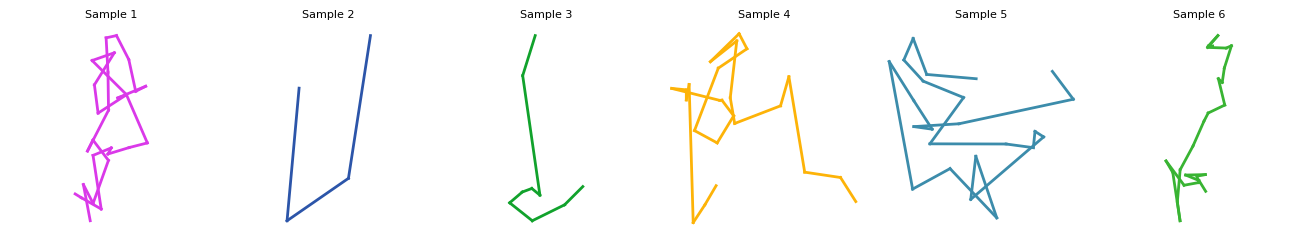

Checkpoint saved: checkpoints/cat/model_step_0.pt
[Step 1500] LR: 0.000095 | Train Loss: 0.2691 | Val Loss: 0.1731


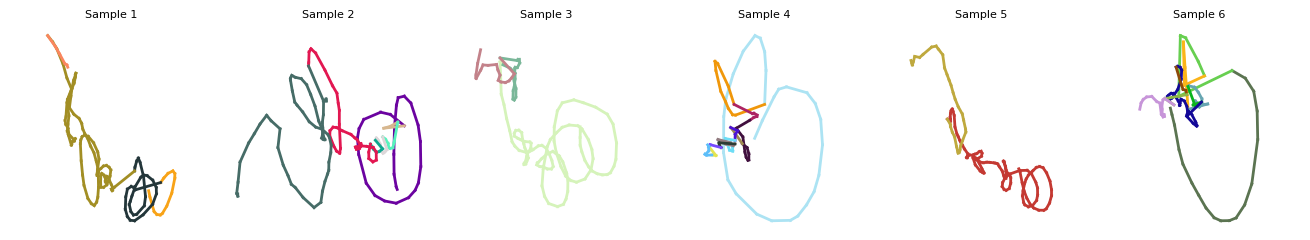

Checkpoint saved: checkpoints/cat/model_step_1500.pt
[Step 3000] LR: 0.000090 | Train Loss: 0.1493 | Val Loss: 0.0849


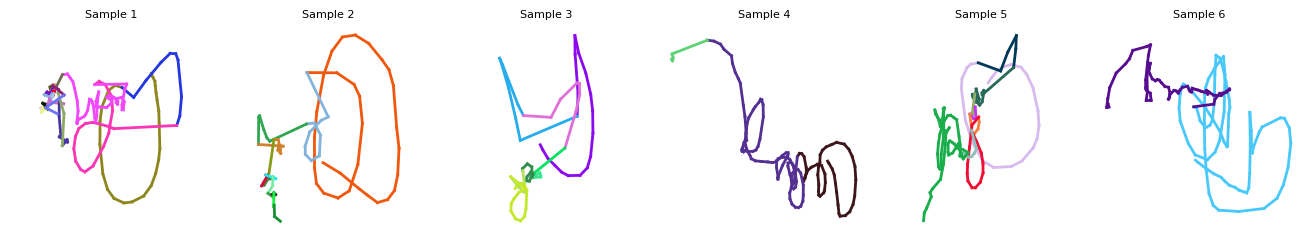

Checkpoint saved: checkpoints/cat/model_step_3000.pt
[Step 4500] LR: 0.000085 | Train Loss: 0.0585 | Val Loss: 0.0663


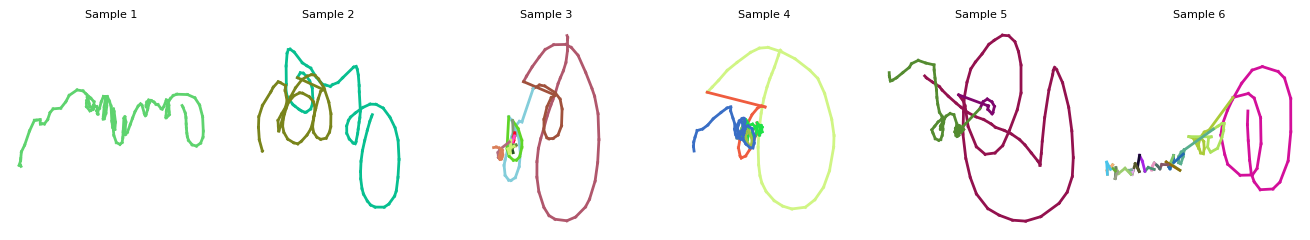

Checkpoint saved: checkpoints/cat/model_step_4500.pt
[Step 6000] LR: 0.000080 | Train Loss: 0.0553 | Val Loss: -0.0191


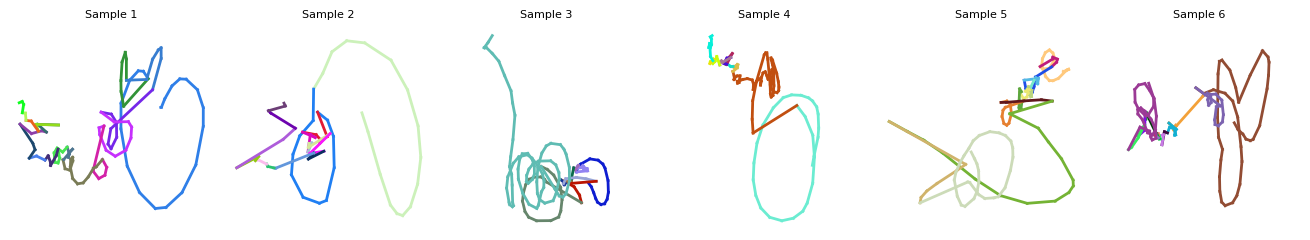

Checkpoint saved: checkpoints/cat/model_step_6000.pt
[Step 7500] LR: 0.000075 | Train Loss: 0.0154 | Val Loss: -0.0016


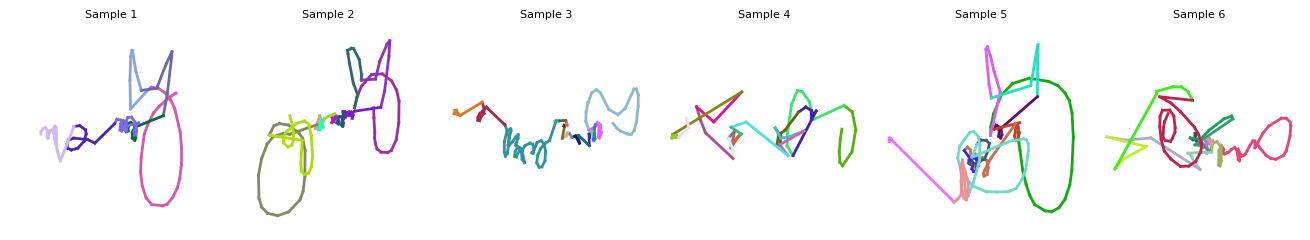

Checkpoint saved: checkpoints/cat/model_step_7500.pt
[Step 9000] LR: 0.000070 | Train Loss: -0.0127 | Val Loss: -0.0332


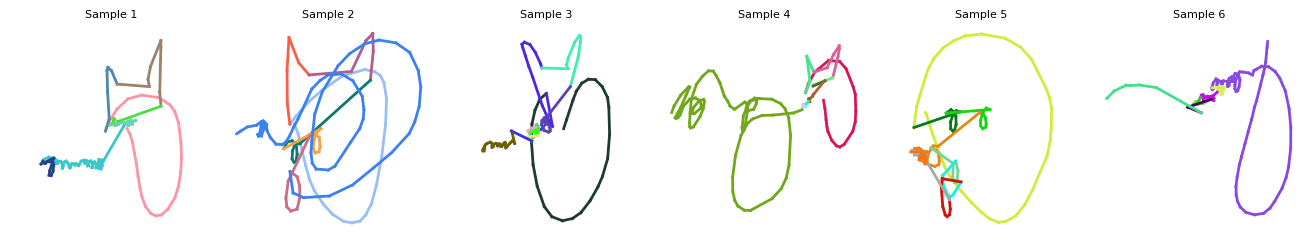

Checkpoint saved: checkpoints/cat/model_step_9000.pt
[Step 10500] LR: 0.000065 | Train Loss: -0.0596 | Val Loss: -0.0304


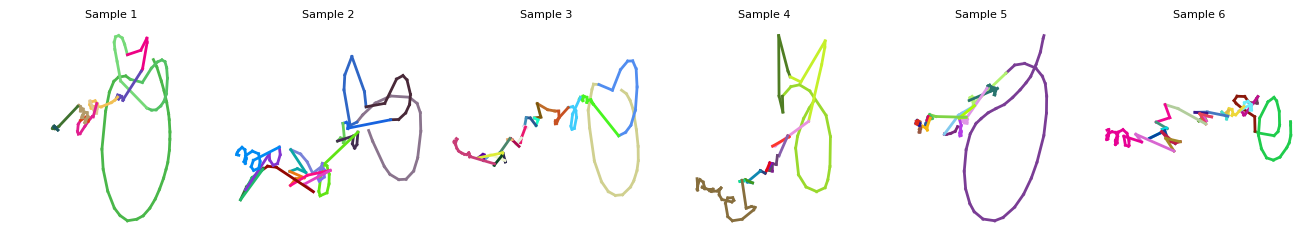

Checkpoint saved: checkpoints/cat/model_step_10500.pt
[Step 12000] LR: 0.000060 | Train Loss: -0.0444 | Val Loss: -0.0389


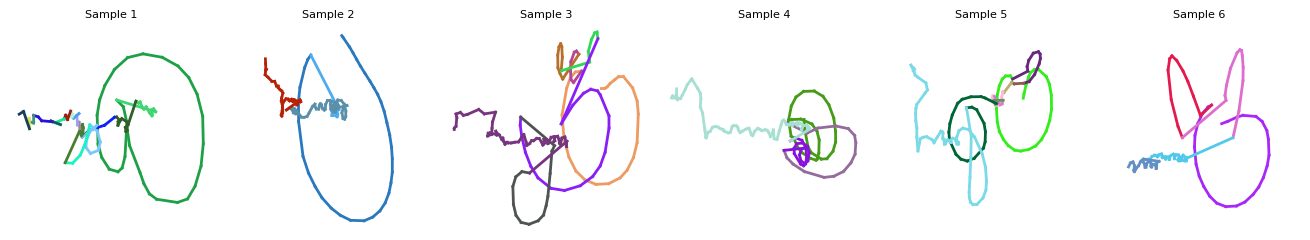

Checkpoint saved: checkpoints/cat/model_step_12000.pt
[Step 13500] LR: 0.000055 | Train Loss: 0.0190 | Val Loss: -0.0614


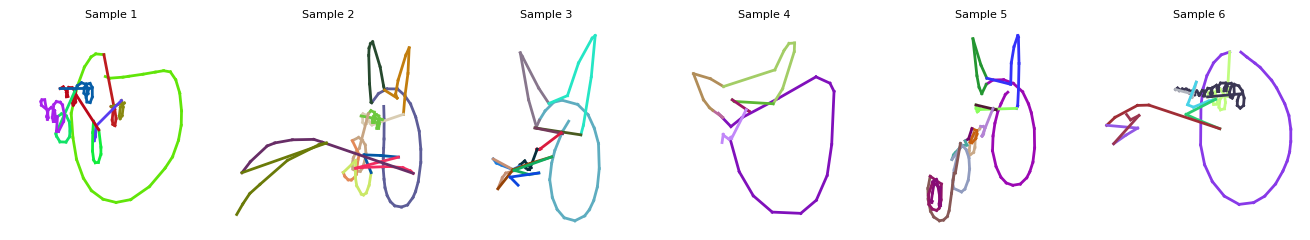

Checkpoint saved: checkpoints/cat/model_step_13500.pt
[Step 15000] LR: 0.000050 | Train Loss: -0.1152 | Val Loss: -0.0827


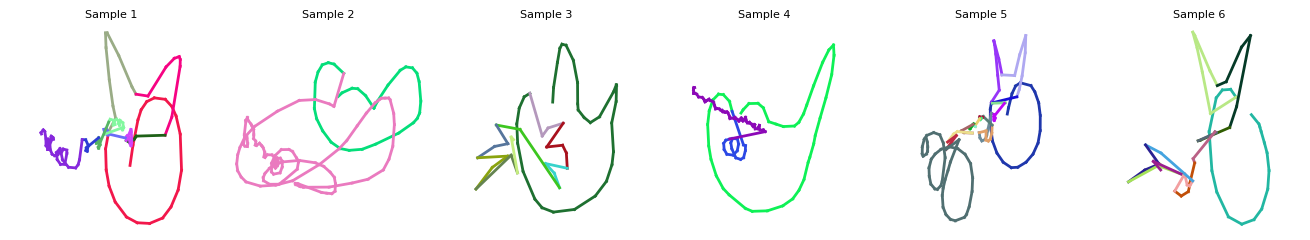

Checkpoint saved: checkpoints/cat/model_step_15000.pt
[Step 16500] LR: 0.000046 | Train Loss: -0.0288 | Val Loss: -0.0668


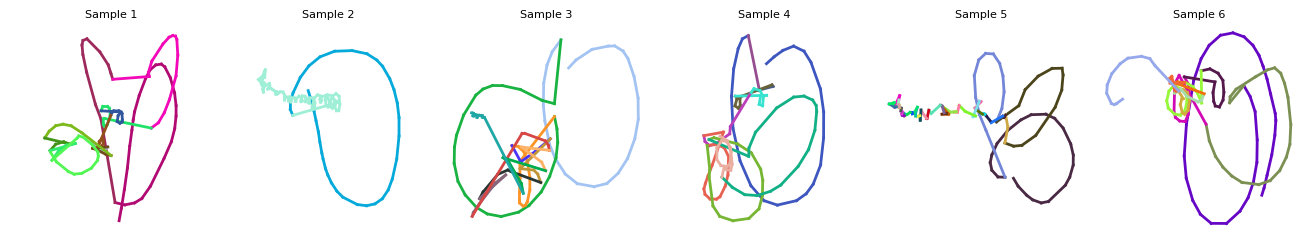

Checkpoint saved: checkpoints/cat/model_step_16500.pt
[Step 18000] LR: 0.000041 | Train Loss: -0.0193 | Val Loss: -0.0649


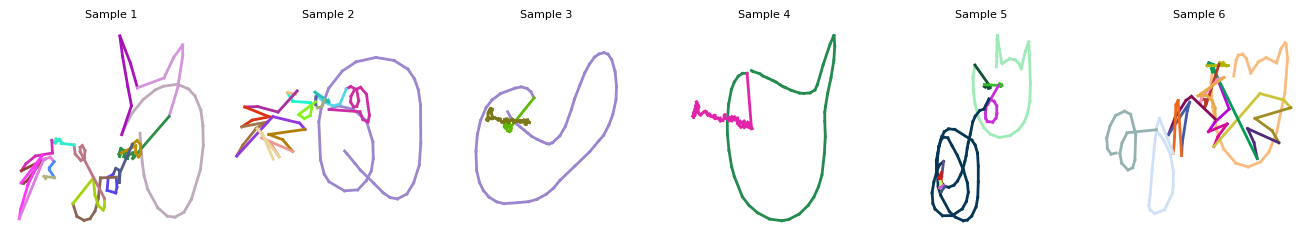

Checkpoint saved: checkpoints/cat/model_step_18000.pt
[Step 19500] LR: 0.000036 | Train Loss: 0.0080 | Val Loss: -0.0931


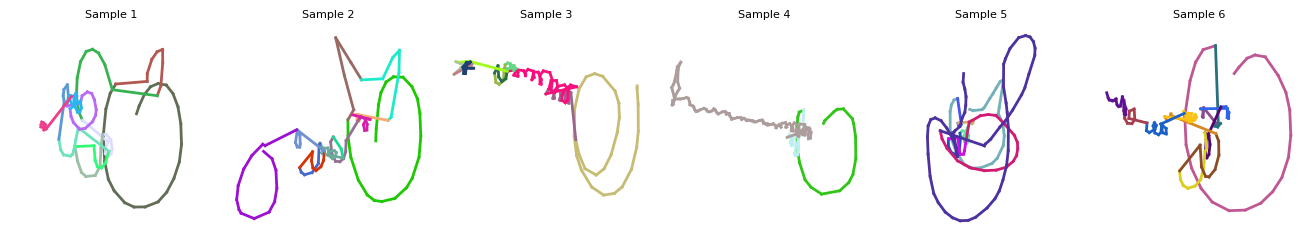

Checkpoint saved: checkpoints/cat/model_step_19500.pt
[Step 21000] LR: 0.000031 | Train Loss: -0.1030 | Val Loss: -0.1187


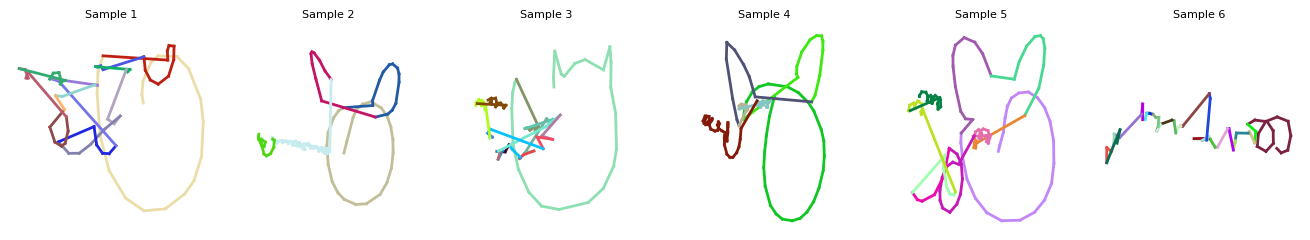

Checkpoint saved: checkpoints/cat/model_step_21000.pt
[Step 22500] LR: 0.000026 | Train Loss: -0.1051 | Val Loss: -0.1104


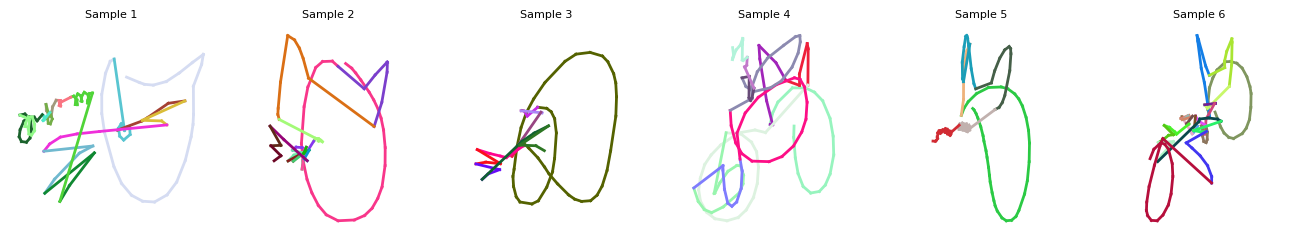

Checkpoint saved: checkpoints/cat/model_step_22500.pt
[Step 24000] LR: 0.000021 | Train Loss: -0.1324 | Val Loss: -0.1112


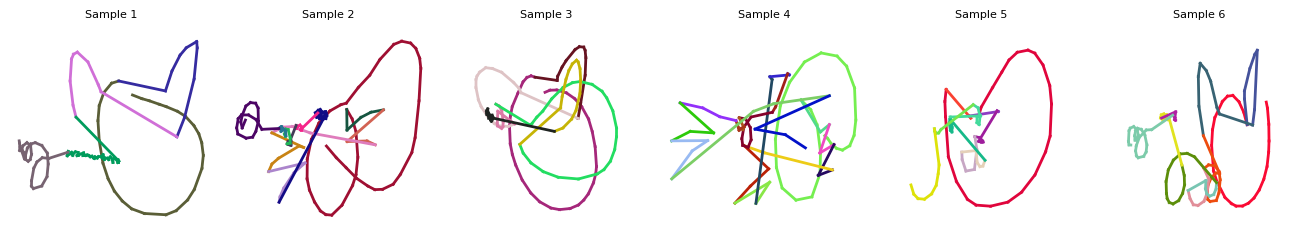

Checkpoint saved: checkpoints/cat/model_step_24000.pt
[Step 25500] LR: 0.000016 | Train Loss: -0.1217 | Val Loss: -0.1130


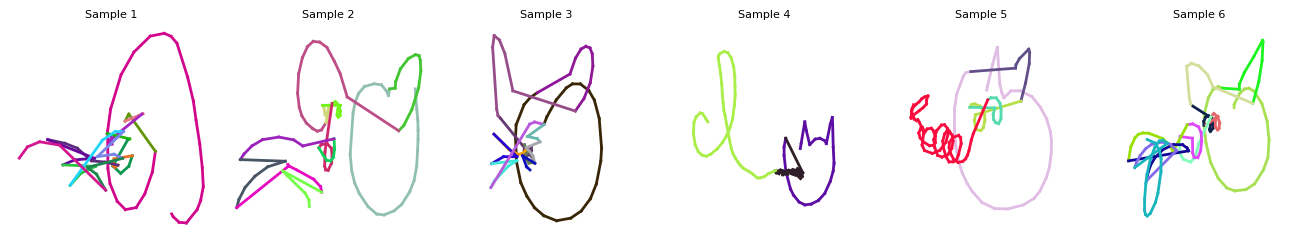

Checkpoint saved: checkpoints/cat/model_step_25500.pt
[Step 27000] LR: 0.000011 | Train Loss: -0.1305 | Val Loss: -0.1408


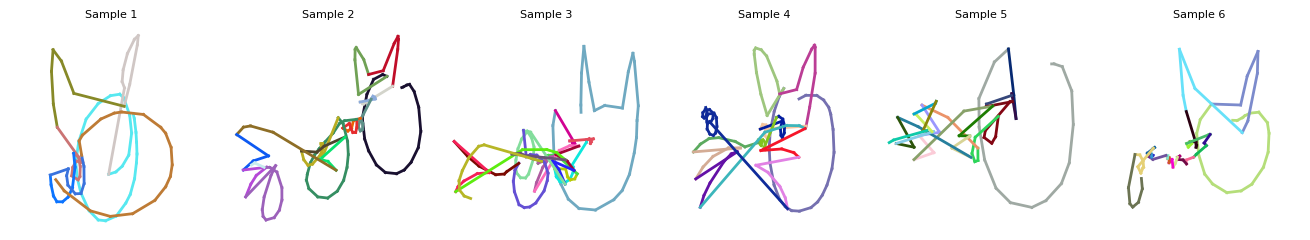

Checkpoint saved: checkpoints/cat/model_step_27000.pt
[Step 28500] LR: 0.000006 | Train Loss: -0.1581 | Val Loss: -0.1606


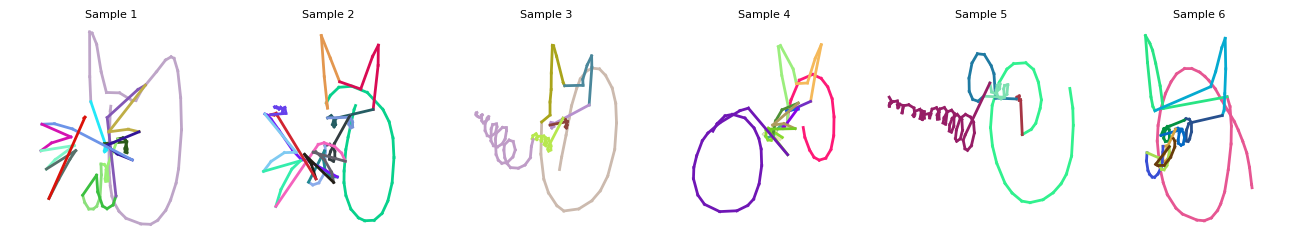

Checkpoint saved: checkpoints/cat/model_step_28500.pt
Training Starting... Class: rabbit
[Step 0] LR: 0.000100 | Train Loss: -0.1863 | Val Loss: 1.0347


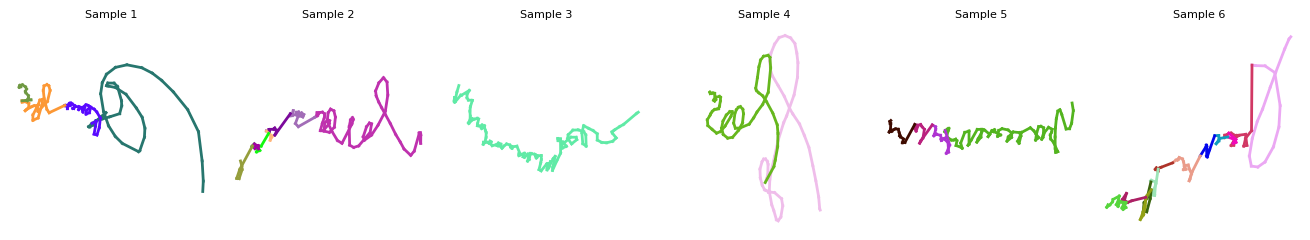

Checkpoint saved: checkpoints/rabbit/model_step_0.pt
[Step 1500] LR: 0.000095 | Train Loss: -0.2209 | Val Loss: -0.1910


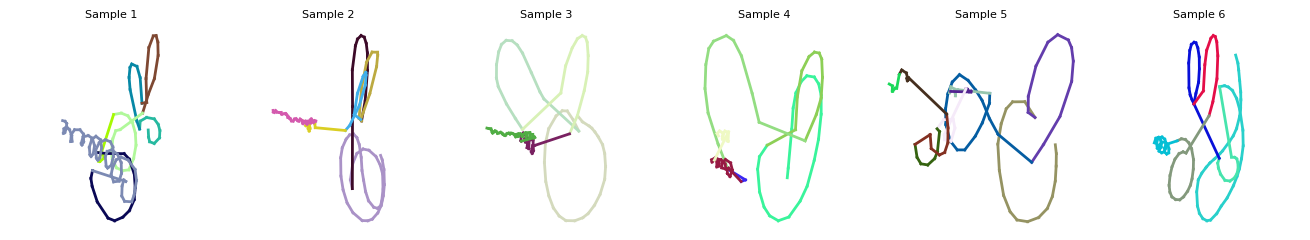

Checkpoint saved: checkpoints/rabbit/model_step_1500.pt
[Step 3000] LR: 0.000090 | Train Loss: -0.1810 | Val Loss: -0.2170


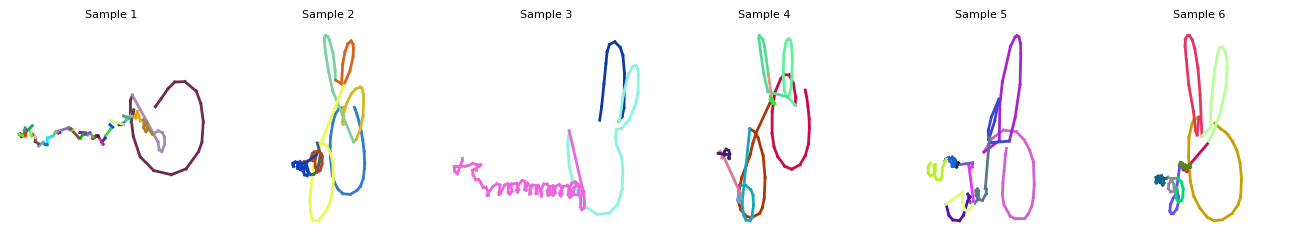

Checkpoint saved: checkpoints/rabbit/model_step_3000.pt
[Step 4500] LR: 0.000085 | Train Loss: -0.1227 | Val Loss: -0.1703


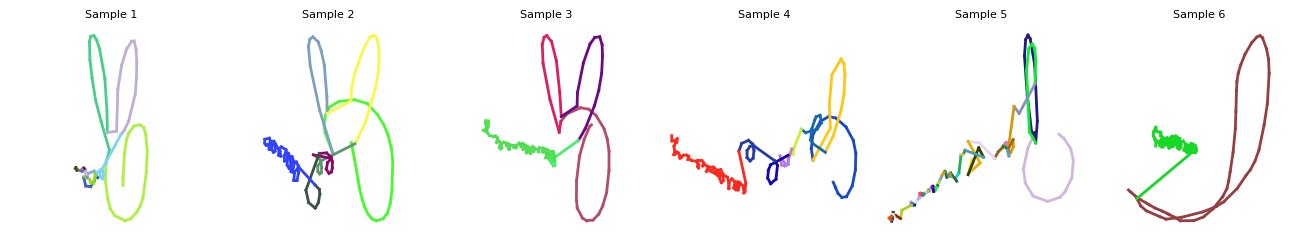

Checkpoint saved: checkpoints/rabbit/model_step_4500.pt
[Step 6000] LR: 0.000080 | Train Loss: -0.2144 | Val Loss: -0.1659


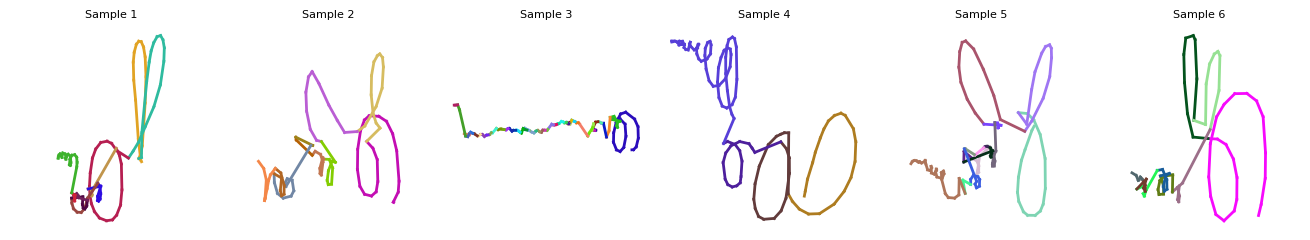

Checkpoint saved: checkpoints/rabbit/model_step_6000.pt
[Step 7500] LR: 0.000075 | Train Loss: -0.1755 | Val Loss: -0.1600


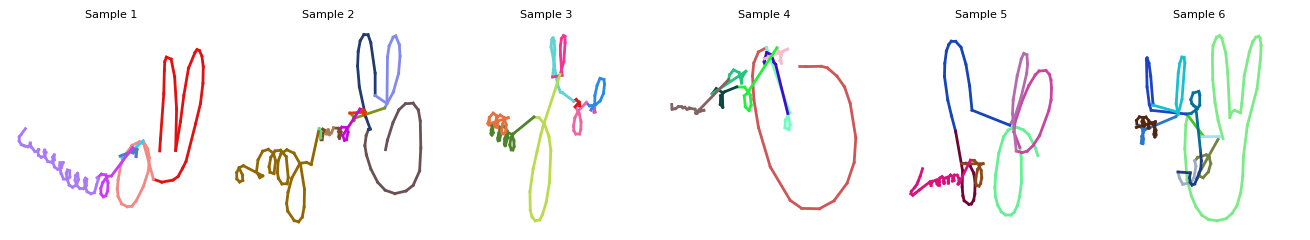

Checkpoint saved: checkpoints/rabbit/model_step_7500.pt
[Step 9000] LR: 0.000070 | Train Loss: -0.2293 | Val Loss: -0.1301


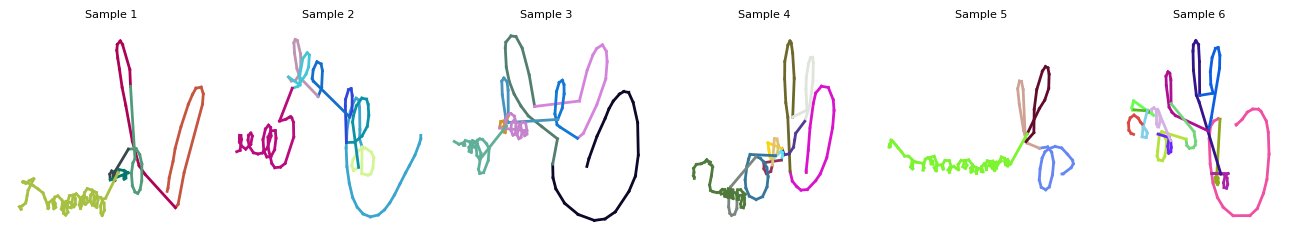

Checkpoint saved: checkpoints/rabbit/model_step_9000.pt
[Step 10500] LR: 0.000065 | Train Loss: -0.1918 | Val Loss: -0.2253


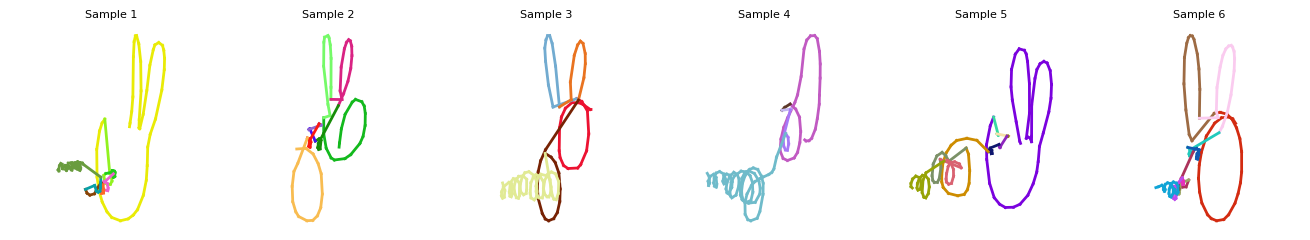

Checkpoint saved: checkpoints/rabbit/model_step_10500.pt
[Step 12000] LR: 0.000060 | Train Loss: -0.2381 | Val Loss: -0.2722


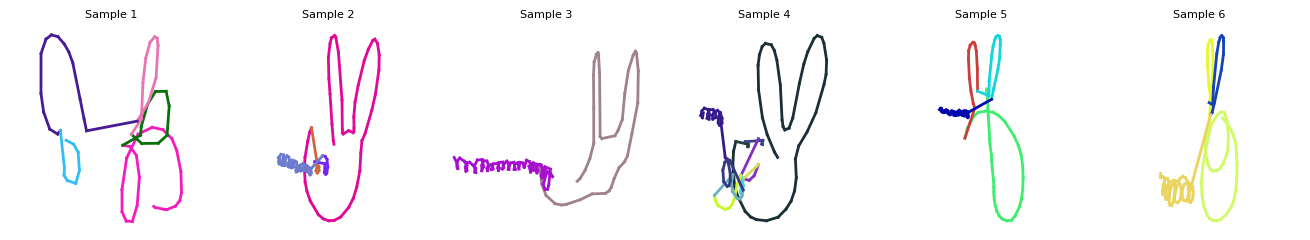

Checkpoint saved: checkpoints/rabbit/model_step_12000.pt
[Step 13500] LR: 0.000055 | Train Loss: -0.3610 | Val Loss: -0.2623


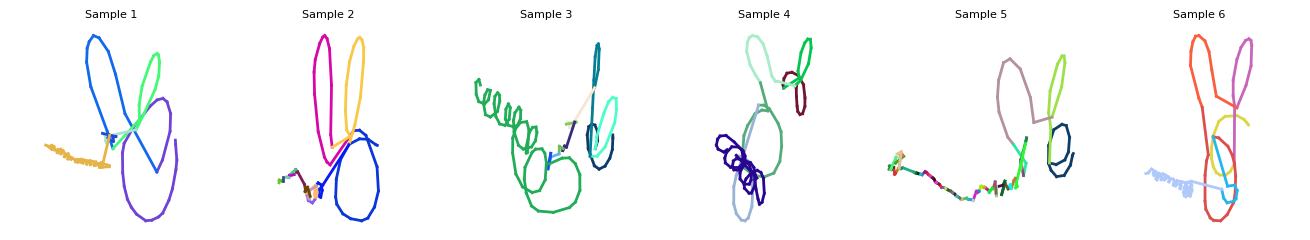

Checkpoint saved: checkpoints/rabbit/model_step_13500.pt
[Step 15000] LR: 0.000050 | Train Loss: -0.2308 | Val Loss: -0.2669


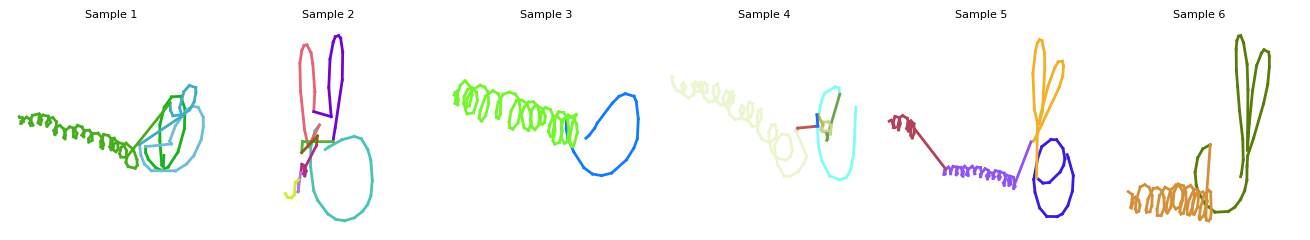

Checkpoint saved: checkpoints/rabbit/model_step_15000.pt
[Step 16500] LR: 0.000046 | Train Loss: -0.2820 | Val Loss: -0.2742


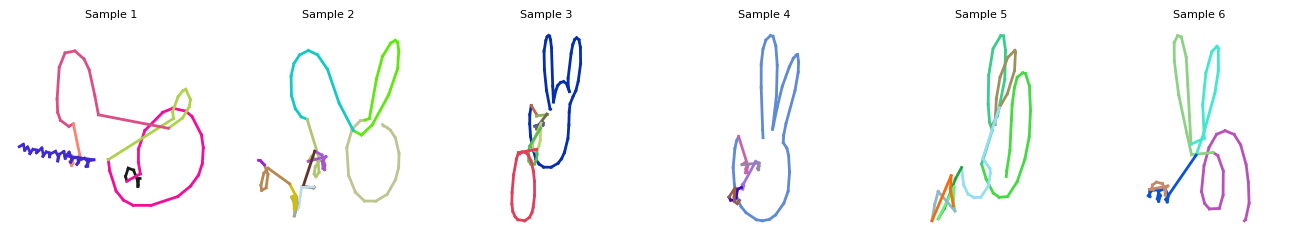

Checkpoint saved: checkpoints/rabbit/model_step_16500.pt
[Step 18000] LR: 0.000041 | Train Loss: -0.2752 | Val Loss: -0.2647


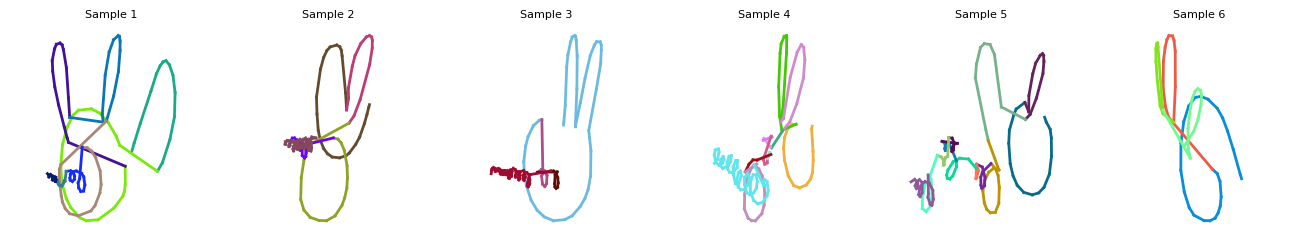

Checkpoint saved: checkpoints/rabbit/model_step_18000.pt
[Step 19500] LR: 0.000036 | Train Loss: -0.1252 | Val Loss: -0.1709


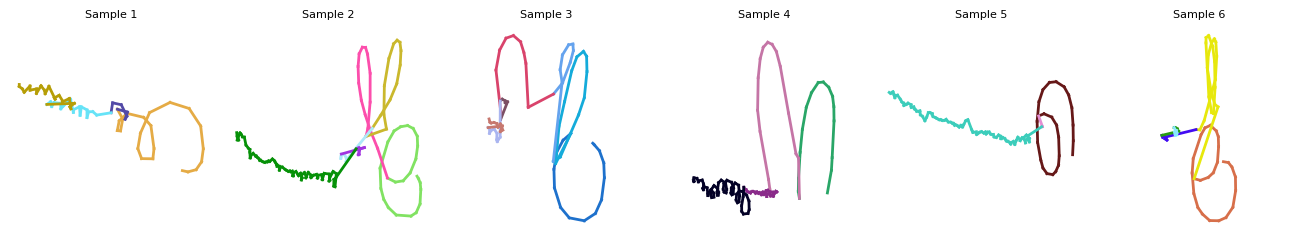

Checkpoint saved: checkpoints/rabbit/model_step_19500.pt
[Step 21000] LR: 0.000031 | Train Loss: -0.1667 | Val Loss: -0.2346


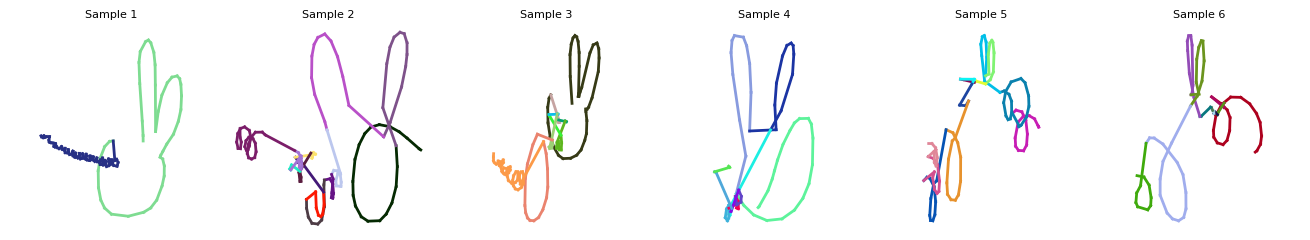

Checkpoint saved: checkpoints/rabbit/model_step_21000.pt
[Step 22500] LR: 0.000026 | Train Loss: -0.2080 | Val Loss: -0.2615


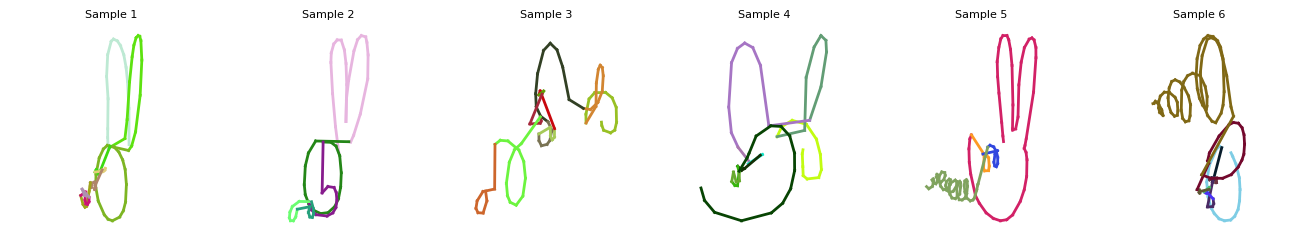

Checkpoint saved: checkpoints/rabbit/model_step_22500.pt
[Step 24000] LR: 0.000021 | Train Loss: -0.2997 | Val Loss: -0.2998


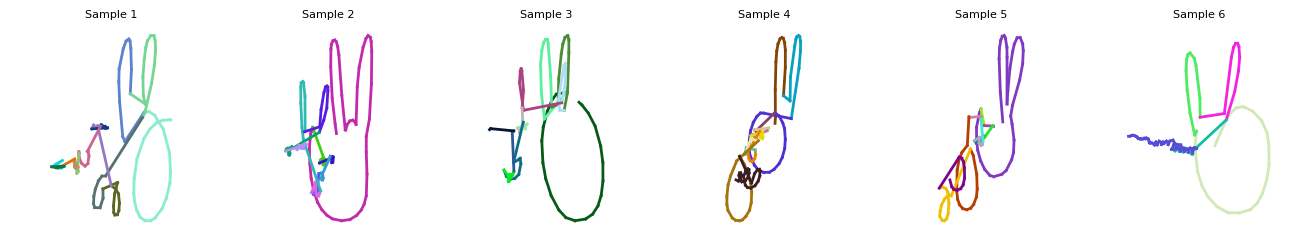

Checkpoint saved: checkpoints/rabbit/model_step_24000.pt
[Step 25500] LR: 0.000016 | Train Loss: -0.3451 | Val Loss: -0.3136


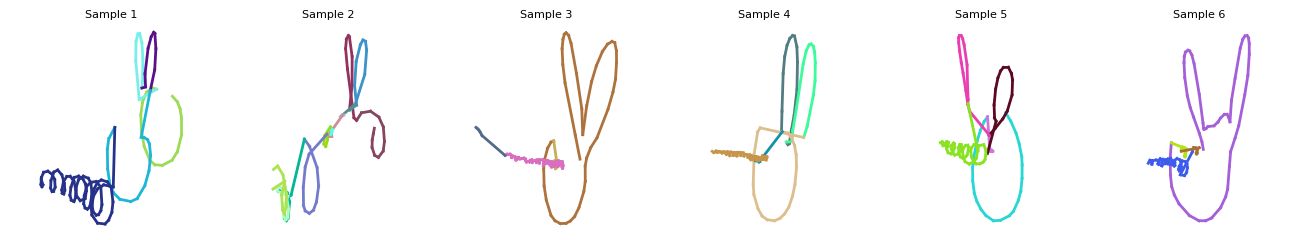

Checkpoint saved: checkpoints/rabbit/model_step_25500.pt
[Step 27000] LR: 0.000011 | Train Loss: -0.3475 | Val Loss: -0.3404


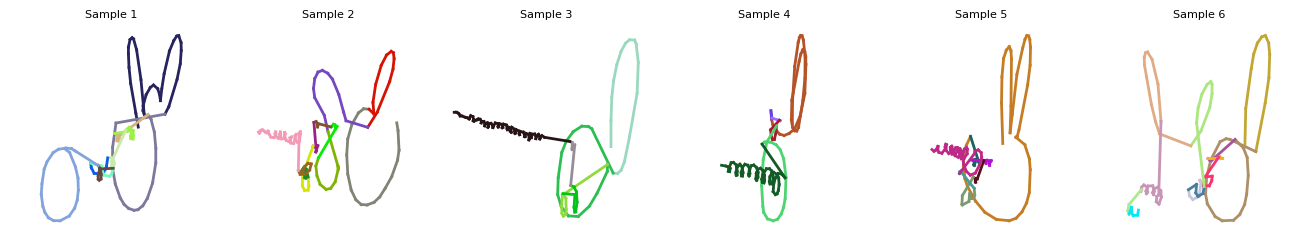

Checkpoint saved: checkpoints/rabbit/model_step_27000.pt
[Step 28500] LR: 0.000006 | Train Loss: -0.2433 | Val Loss: -0.3130


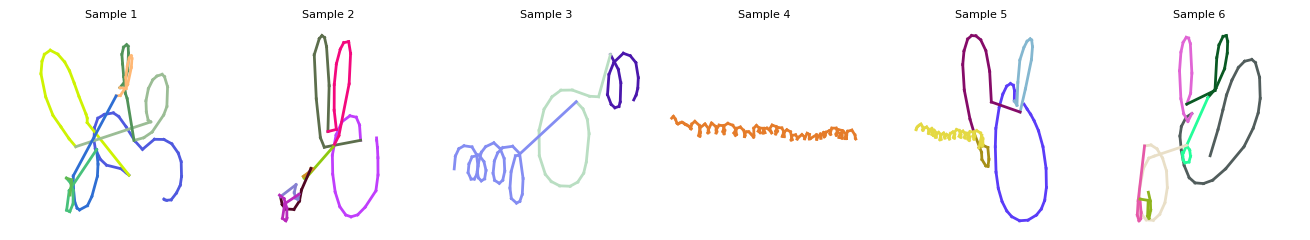

Checkpoint saved: checkpoints/rabbit/model_step_28500.pt
Training Starting... Class: bus
[Step 0] LR: 0.000100 | Train Loss: 0.1797 | Val Loss: 0.6161


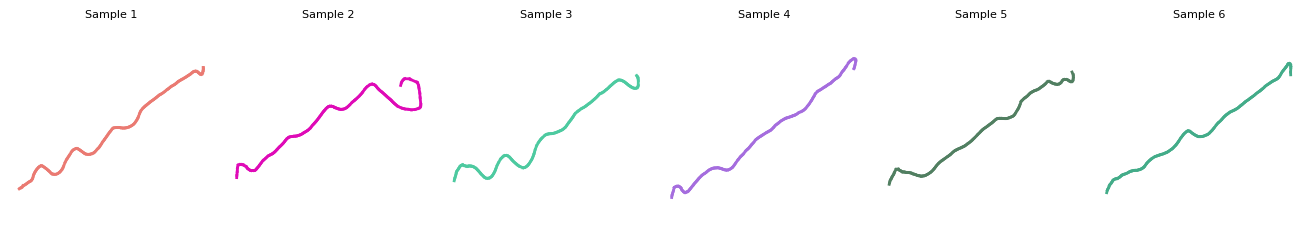

Checkpoint saved: checkpoints/bus/model_step_0.pt
[Step 1500] LR: 0.000095 | Train Loss: -0.1078 | Val Loss: -0.1138


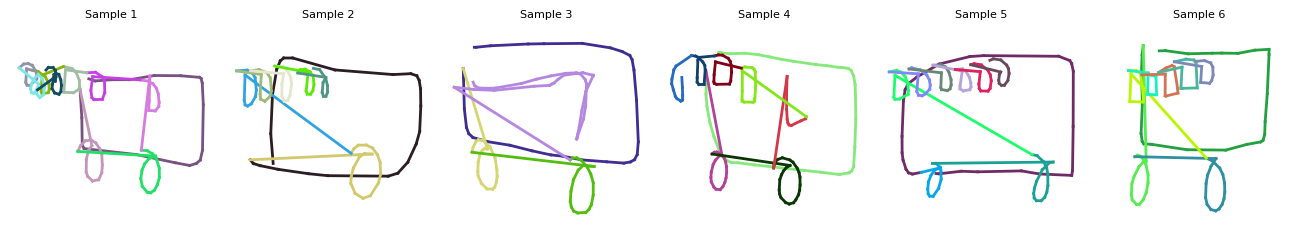

Checkpoint saved: checkpoints/bus/model_step_1500.pt
[Step 3000] LR: 0.000090 | Train Loss: -0.0682 | Val Loss: -0.0955


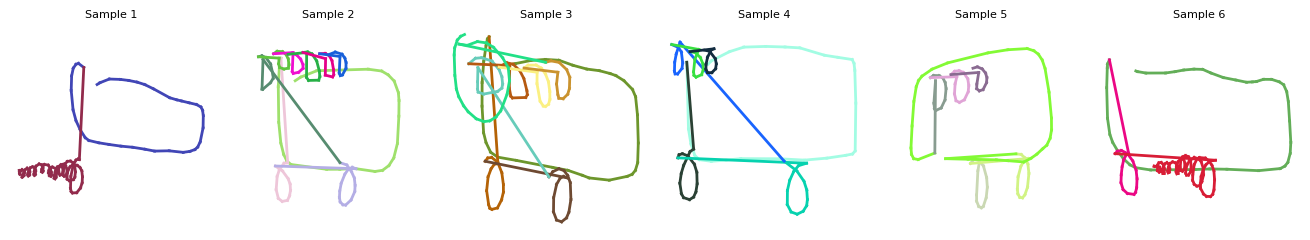

Checkpoint saved: checkpoints/bus/model_step_3000.pt
[Step 4500] LR: 0.000085 | Train Loss: -0.1169 | Val Loss: -0.1096


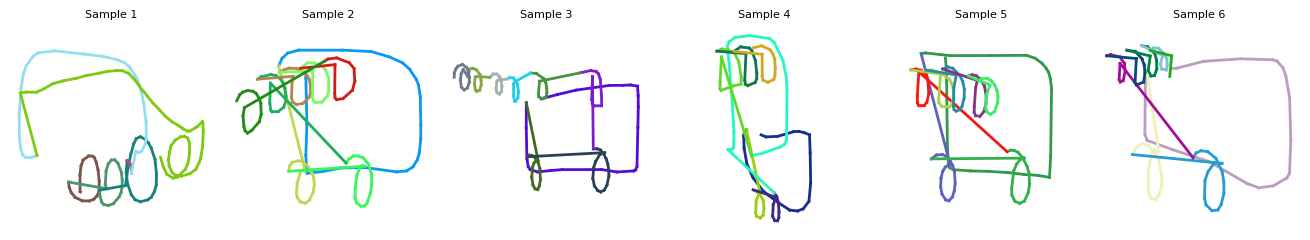

Checkpoint saved: checkpoints/bus/model_step_4500.pt
[Step 6000] LR: 0.000080 | Train Loss: -0.1282 | Val Loss: -0.1152


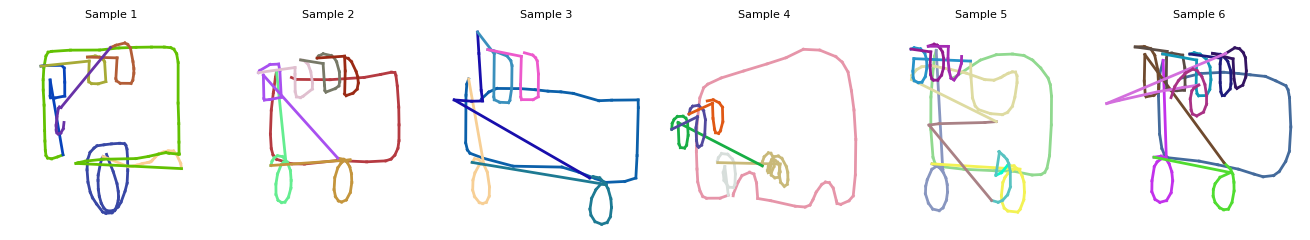

Checkpoint saved: checkpoints/bus/model_step_6000.pt
[Step 7500] LR: 0.000075 | Train Loss: -0.1017 | Val Loss: -0.1280


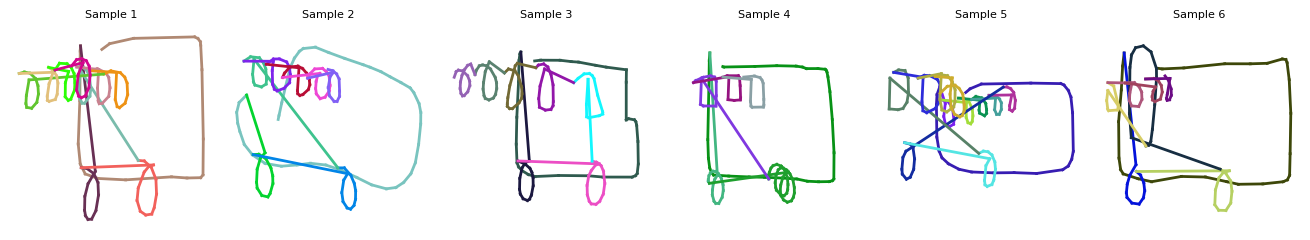

Checkpoint saved: checkpoints/bus/model_step_7500.pt
[Step 9000] LR: 0.000070 | Train Loss: -0.1648 | Val Loss: -0.1478


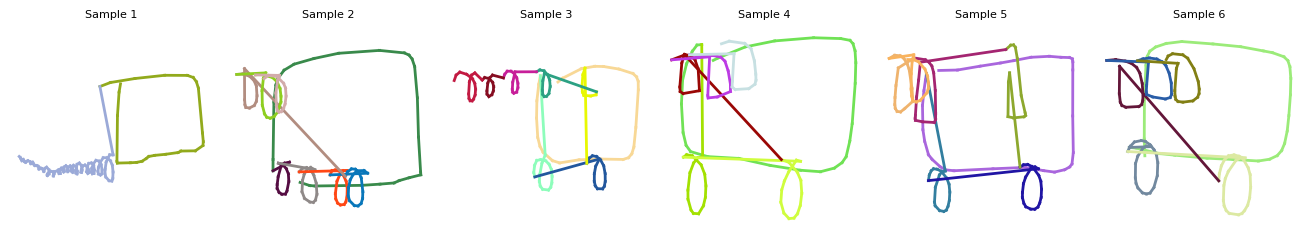

Checkpoint saved: checkpoints/bus/model_step_9000.pt
[Step 10500] LR: 0.000065 | Train Loss: -0.2352 | Val Loss: -0.1640


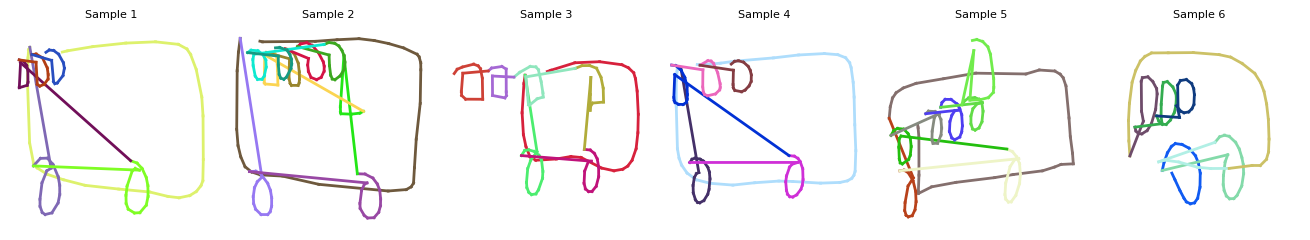

Checkpoint saved: checkpoints/bus/model_step_10500.pt
[Step 12000] LR: 0.000060 | Train Loss: -0.1649 | Val Loss: -0.1741


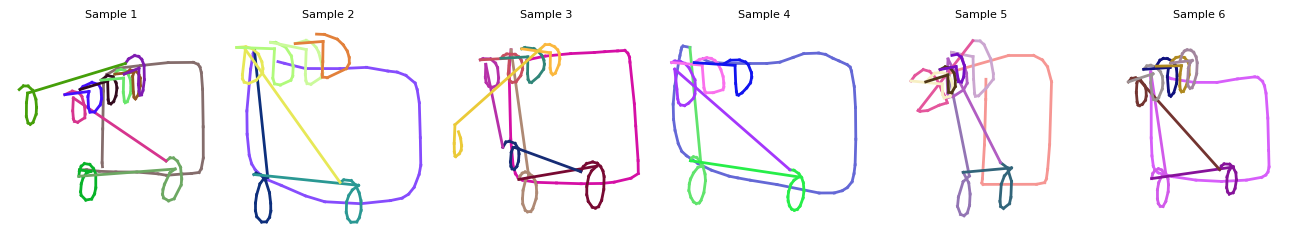

Checkpoint saved: checkpoints/bus/model_step_12000.pt
[Step 13500] LR: 0.000055 | Train Loss: -0.1711 | Val Loss: -0.2034


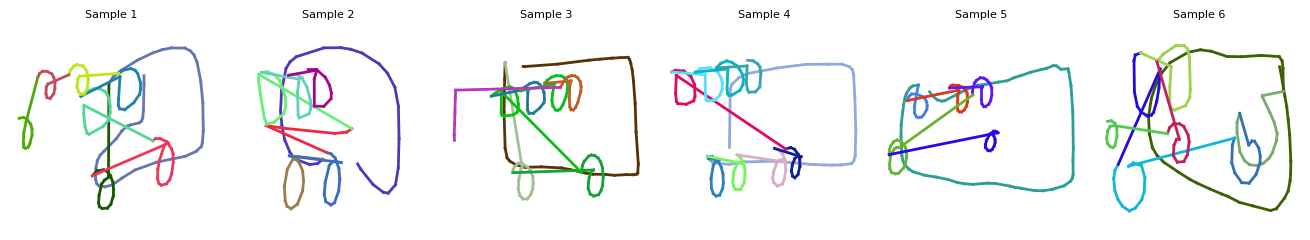

Checkpoint saved: checkpoints/bus/model_step_13500.pt
[Step 15000] LR: 0.000050 | Train Loss: -0.1601 | Val Loss: -0.2112


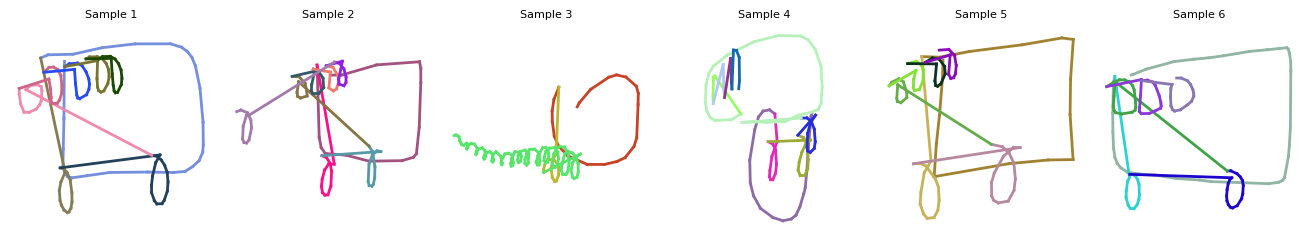

Checkpoint saved: checkpoints/bus/model_step_15000.pt
[Step 16500] LR: 0.000046 | Train Loss: -0.1405 | Val Loss: -0.2285


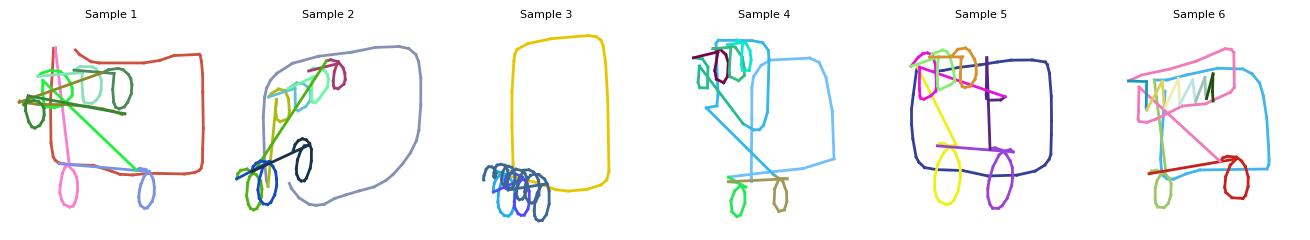

Checkpoint saved: checkpoints/bus/model_step_16500.pt
[Step 18000] LR: 0.000041 | Train Loss: -0.1512 | Val Loss: -0.2139


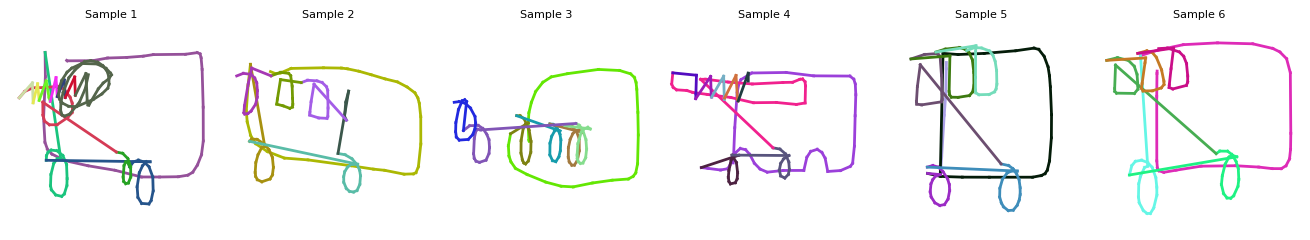

Checkpoint saved: checkpoints/bus/model_step_18000.pt
[Step 19500] LR: 0.000036 | Train Loss: -0.2475 | Val Loss: -0.2381


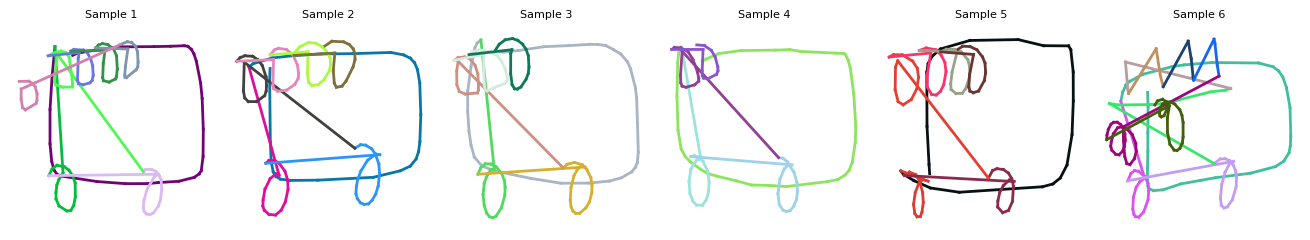

Checkpoint saved: checkpoints/bus/model_step_19500.pt
[Step 21000] LR: 0.000031 | Train Loss: -0.1930 | Val Loss: -0.2152


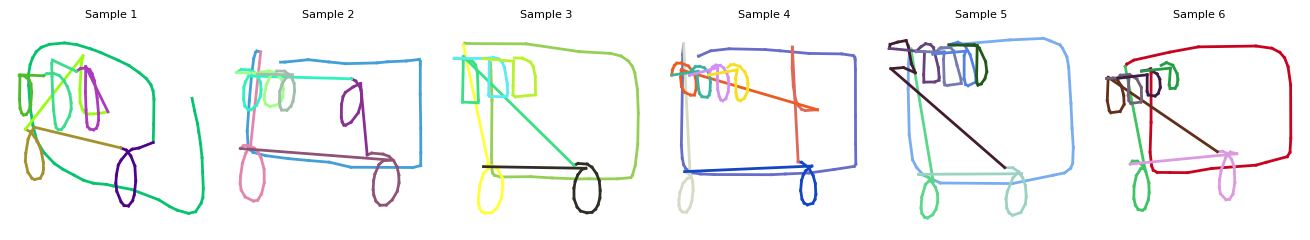

Checkpoint saved: checkpoints/bus/model_step_21000.pt
[Step 22500] LR: 0.000026 | Train Loss: -0.1926 | Val Loss: -0.2508


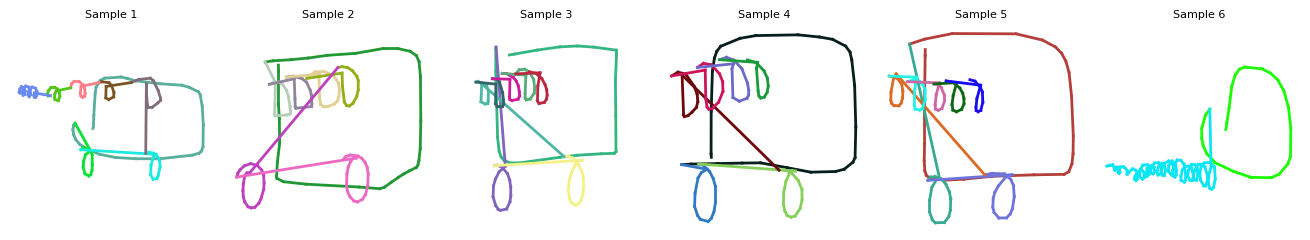

Checkpoint saved: checkpoints/bus/model_step_22500.pt
[Step 24000] LR: 0.000021 | Train Loss: -0.1709 | Val Loss: -0.2847


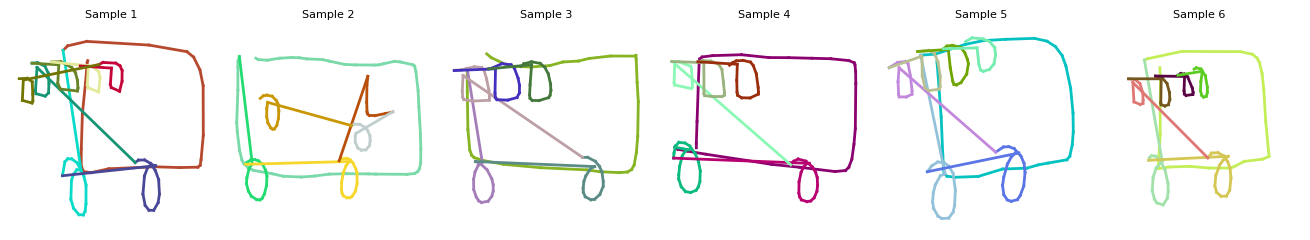

Checkpoint saved: checkpoints/bus/model_step_24000.pt
[Step 25500] LR: 0.000016 | Train Loss: -0.2783 | Val Loss: -0.2670


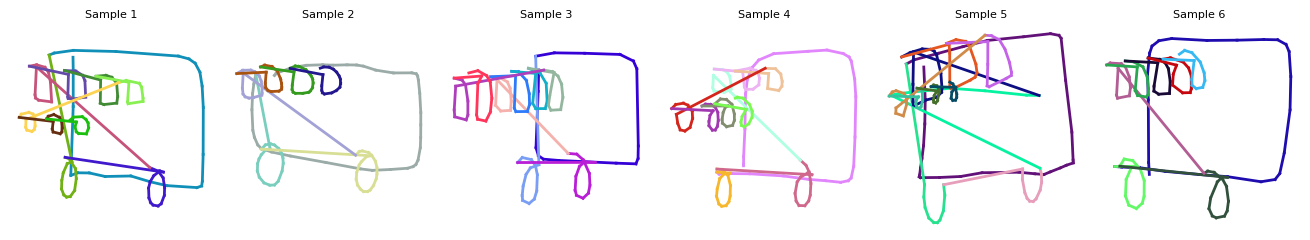

Checkpoint saved: checkpoints/bus/model_step_25500.pt
[Step 27000] LR: 0.000011 | Train Loss: -0.2696 | Val Loss: -0.2720


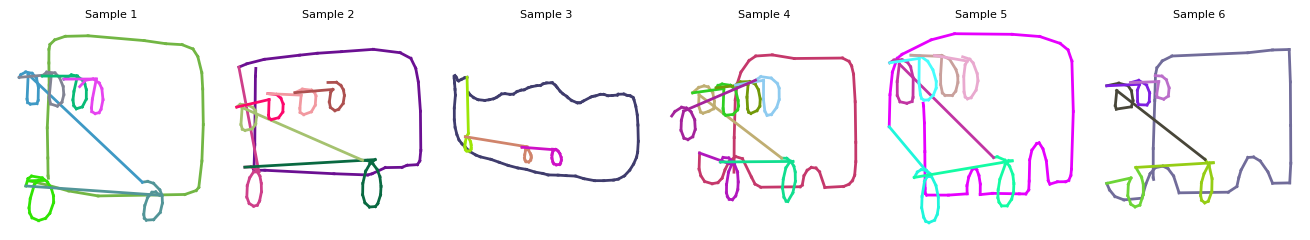

Checkpoint saved: checkpoints/bus/model_step_27000.pt
[Step 28500] LR: 0.000006 | Train Loss: -0.2779 | Val Loss: -0.2744


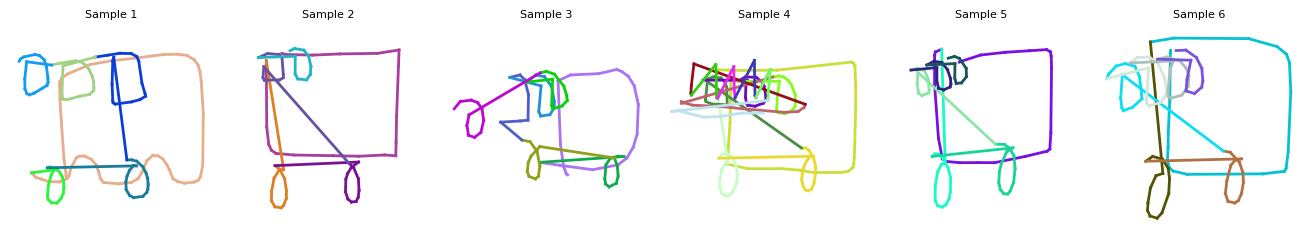

Checkpoint saved: checkpoints/bus/model_step_28500.pt


In [28]:
for data_class in DATA_CLASSES:
    print("Training Starting... Class:", data_class)
    train_loop(
        model=model,
        writer=writer,
        training_iters=TRAINING_ITERS,
        eval_interval=EVAL_INTERVAL,
        batch_config=batch_config,
        learning_rate=LEARNING_RATE,
        checkpoint_dir=f"checkpoints/{data_class}",
        max_sequence_length=max_sequence_length,
        device=DEVICE,
        data_class=data_class
    )

## TESTING

### Create GIF

In [29]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

In [30]:
def save_stroke_frame(ax, x_vals, y_vals, drawing_data, current_index, pad=10):
    """
    Draws the strokes up to the current index and saves the frame.
    """
    ax.clear()
    min_x, max_x = np.min(x_vals), np.max(x_vals)
    min_y, max_y = np.min(y_vals), np.max(y_vals)
    ax.set_xlim(min_x - pad, max_x + pad)
    ax.set_ylim(max_y + pad, min_y - pad)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    temp_stroke = []
    for j in range(current_index + 1):
        abs_x, abs_y = x_vals[j], y_vals[j]
        temp_stroke.append([abs_x, abs_y])
        pen_state = drawing_data[j, 2]
        if pen_state == 1.0 or pen_state == 2.0:
            if len(temp_stroke) > 1:
                arr = np.array(temp_stroke)
                ax.plot(arr[:, 0], arr[:, 1], 'k-', linewidth=2)
            temp_stroke = []
    # Draw the current stroke in progress
    if len(temp_stroke) > 1:
        arr = np.array(temp_stroke)
        ax.plot(arr[:, 0], arr[:, 1], 'k-', linewidth=2)

In [31]:
def get_latest_checkpoint(checkpoint_dir):
    """
    Get max number into related folder
    """
    files = os.listdir(checkpoint_dir)
    model_files = [f for f in files if re.match(r"model_step_(\d+)\.pt", f)]
    if not model_files:
        raise FileNotFoundError(f"{checkpoint_dir} no found model_step_*.pt!")
    model_files.sort(key=lambda x: int(re.findall(r"model_step_(\d+)\.pt", x)[0]), reverse=True)
    return os.path.join(checkpoint_dir, model_files[0])

In [32]:
def denormalize_stroke(stroke, x_mean, x_std, y_mean, y_std):
    """
    Reverts the normalization and clipping applied to the stroke data.
    Args:
        stroke (torch.Tensor): Normalized stroke tensor of shape (N, 3).
        x_mean, x_std, y_mean, y_std (float): Normalization parameters.
    Returns:
        np.ndarray: Denormalized stroke array of shape (N, 3).
    """
    stroke = stroke.cpu().numpy()
    stroke[:, 0] = stroke[:, 0] * x_std + x_mean
    stroke[:, 1] = stroke[:, 1] * y_std + y_mean
    return stroke

In [33]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import imageio

def save_stroke_frame(ax, x_vals, y_vals, drawing_data, current_index, pad=10):
    """
    Draws the strokes up to the current index and saves the frame.
    """
    ax.clear()
    min_x, max_x = np.min(x_vals), np.max(x_vals)
    min_y, max_y = np.min(y_vals), np.max(y_vals)
    ax.set_xlim(min_x - pad, max_x + pad)
    ax.set_ylim(max_y + pad, min_y - pad)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    temp_stroke = []
    for j in range(current_index + 1):
        abs_x, abs_y = x_vals[j], y_vals[j]
        temp_stroke.append([abs_x, abs_y])
        pen_state = drawing_data[j, 2]
        if pen_state == 1.0 or pen_state == 2.0:
            if len(temp_stroke) > 1:
                arr = np.array(temp_stroke)
                ax.plot(arr[:, 0], arr[:, 1], 'k-', linewidth=2)
            temp_stroke = []
    # Draw the current stroke in progress
    if len(temp_stroke) > 1:
        arr = np.array(temp_stroke)
        ax.plot(arr[:, 0], arr[:, 1], 'k-', linewidth=2)

def visualize_drawing_as_gif(drawing_data, filename="generated_drawing.gif", fps=10):
    """
    Visualizes a given drawing (denormalized) as a step-by-step GIF.

    Args:
        drawing_data (np.ndarray): Array of shape (N, 3) in [x, y, pen_state] format.
        filename (str): Output GIF file name.
        fps (int): Frames per second for the GIF.

    Returns:
        None. Saves the GIF to the specified filename.
    """
    if len(drawing_data) == 0:
        print("Drawing data is empty. Nothing to visualize.")
        return

    temp_dir = "temp_frames"
    os.makedirs(temp_dir, exist_ok=True)
    images = []
    fig, ax = plt.subplots(figsize=(6, 6))

    x_vals = np.cumsum(drawing_data[:, 0])
    y_vals = np.cumsum(drawing_data[:, 1])

    for i in range(len(drawing_data)):
        save_stroke_frame(ax, x_vals, y_vals, drawing_data, i)
        frame_path = os.path.join(temp_dir, f"frame_{i:04d}.png")
        plt.savefig(frame_path, bbox_inches='tight', pad_inches=0, dpi=100)
        images.append(imageio.v2.imread(frame_path))

    plt.close(fig)
    imageio.mimsave(filename, images, fps=fps)
    print(f"GIF '{filename}' successfully created.")
    shutil.rmtree(temp_dir)
    print(f"Temporary folder '{temp_dir}' removed.")

In [34]:
def denormalize_stroke(stroke, x_mean, x_std, y_mean, y_std):
    """
    Reverts the normalization and clipping applied to the stroke data.
    Args:
        stroke (torch.Tensor): Normalized stroke tensor of shape (N, 3).
        x_mean, x_std, y_mean, y_std (float): Normalization parameters.
    Returns:
        np.ndarray: Denormalized stroke array of shape (N, 3).
    """
    stroke = stroke.cpu().numpy()
    stroke[:, 0] = stroke[:, 0] * x_std + x_mean
    stroke[:, 1] = stroke[:, 1] * y_std + y_mean
    return stroke

for data_class in DATA_CLASSES:
    print(f"\n{'='*20}\nTesting and visualization for class: {data_class}\n{'='*20}")

    # 1. Load the latest model checkpoint for this class
    checkpoint_dir = f"checkpoints/{data_class}"
    model_path = get_latest_checkpoint(checkpoint_dir)
    print(f"Latest model for {data_class}: {model_path}")

    model = TransformerModel().to(DEVICE)
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 2. Prepare a test batch (batch size 1 for GIF generation)
    test_batch_config = BatchConfig(
        split_name="test",
        batch_size=1,
        max_sequence_length=max_sequence_length,
        x_mean=x_mean,
        x_std=x_std,
        y_mean=y_mean,
        y_std=y_std,
        device=DEVICE
    )
    inputs, targets, mask = create_batch_multiclass(test_batch_config, data_class)

    # 3. Generate a sample from the model
    with torch.no_grad():
        y_pred = model.sample(inputs)

    # 4. Denormalize the predicted stroke
    pred_stroke = denormalize_stroke(y_pred[0], x_mean, x_std, y_mean, y_std)

    # 5. Visualize as GIF
    gif_filename = f"generated_{data_class}.gif"
    visualize_drawing_as_gif(pred_stroke, filename=gif_filename, fps=10)
    print(f"GIF saved as {gif_filename}")


Testing and visualization for class: cat
Latest model for cat: checkpoints/cat/model_step_28500.pt
GIF 'generated_cat.gif' successfully created.
Temporary folder 'temp_frames' removed.
GIF saved as generated_cat.gif

Testing and visualization for class: rabbit
Latest model for rabbit: checkpoints/rabbit/model_step_28500.pt
GIF 'generated_rabbit.gif' successfully created.
Temporary folder 'temp_frames' removed.
GIF saved as generated_rabbit.gif

Testing and visualization for class: bus
Latest model for bus: checkpoints/bus/model_step_28500.pt
GIF 'generated_bus.gif' successfully created.
Temporary folder 'temp_frames' removed.
GIF saved as generated_bus.gif


### Metric Testing

In [35]:
def sketch_to_image_pil(drawing, size=128):
    from PIL import Image, ImageDraw
    import numpy as np
    img = Image.new('L', (size, size), color=255)
    draw = ImageDraw.Draw(img)
    for stroke in drawing:
        x = np.array(stroke[0])
        y = np.array(stroke[1])
        if len(x) > 1:
            x_norm = (x - x.min()) / (x.max() - x.min() + 1e-8) * (size - 1)
            y_norm = (y - y.min()) / (y.max() - y.min() + 1e-8) * (size - 1)
            points = list(zip(x_norm, y_norm))
            draw.line(points, fill=0, width=2)
    img = np.array(img).astype(np.float32) / 255.0
    img = np.stack([img, img, img], axis=0)
    return img

In [36]:
def load_test_data(data_class):
    """
    Loads the test data for a given class.
    """
    with open(f"subset/{data_class}/indices.json") as f:
        indices = json.load(f)
    with open(f"data/{data_class}.ndjson") as f:
        raw_data = ndjson.load(f)
    return [raw_data[i] for i in indices['test']]

In [37]:
def load_trained_model(data_class, device):
    """
    Loads the latest trained model checkpoint for a given class.
    """
    checkpoint_dir = f"checkpoints/{data_class}"
    model_path = get_latest_checkpoint(checkpoint_dir)
    print(f"Latest model for {data_class}: {model_path}")
    model = TransformerModel().to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [38]:
generated_drawings = []
def generate_fake_drawings(model, num_samples, device):
    """
    Generates fake drawings using the model.
    """
    with torch.no_grad():
        for _ in range(num_samples):
            x_start = torch.zeros(1, 1, 3).to(device)
            fake_stroke = model.sample(x_start)
            drawing = []
            x, y = 0, 0
            xs, ys = [x], [y]
            for dx, dy, pen in fake_stroke[0].cpu().numpy():
                x += dx
                y += dy
                xs.append(x)
                ys.append(y)
                if pen == 1 or pen == 2:
                    drawing.append([xs, ys])
                    xs, ys = [x], [y]
            if xs and ys and len(xs) > 1:
                drawing.append([xs, ys])
            generated_drawings.append(drawing)
    return generated_drawings

In [39]:
def drawings_to_images(drawings, size=128):
    """
    Converts a list of drawings to image arrays.
    """
    return np.stack([sketch_to_image_pil(d, size=size) for d in drawings])

In [40]:
def compute_fid_kid(real_images, fake_images, device):
    """
    Computes FID and KID scores between real and fake images.
    """
    fid = FrechetInceptionDistance(normalize=True).to(device)
    kid = KernelInceptionDistance(subset_size=50, normalize=True).to(device)
    real_images_t = torch.tensor(real_images, dtype=torch.float32).to(device)
    fake_images_t = torch.tensor(fake_images, dtype=torch.float32).to(device)
    fid.update(real_images_t, real=True)
    fid.update(fake_images_t, real=False)
    fid_score = fid.compute().item()
    kid.update(real_images_t, real=True)
    kid.update(fake_images_t, real=False)
    kid_mean, kid_std = kid.compute()
    return fid_score, kid_mean.item(), kid_std.item()

In [41]:
def evaluate_class(data_class, num_samples=200, image_size=128, device='cuda'):
    """
    Runs the full evaluation pipeline for a single class.
    """
    print(f"\n{'='*20}\nEvaluating FID/KID for class: {data_class}\n{'='*20}")
    test_data = load_test_data(data_class)
    model = load_trained_model(data_class, device)
    fake_drawings = generate_fake_drawings(model, num_samples, device)
    fake_images = drawings_to_images(fake_drawings, size=image_size)
    real_images = drawings_to_images([d['drawing'] for d in test_data[:num_samples]], size=image_size)
    fid, kid_mean, kid_std = compute_fid_kid(real_images, fake_images, device)
    print(f"{data_class} FID: {fid:.3f} | KID: {kid_mean:.5f} ± {kid_std:.5f}")

for data_class in DATA_CLASSES:
    evaluate_class(data_class, num_samples=50, image_size=128, device=DEVICE)


Evaluating FID/KID for class: cat
Latest model for cat: checkpoints/cat/model_step_28500.pt


/home/onur/miniconda3/envs/torch/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


cat FID: 728.841 | KID: 1.21556 ± 0.00000

Evaluating FID/KID for class: rabbit
Latest model for rabbit: checkpoints/rabbit/model_step_28500.pt
rabbit FID: 754.951 | KID: 1.22797 ± 0.00825

Evaluating FID/KID for class: bus
Latest model for bus: checkpoints/bus/model_step_28500.pt
bus FID: 685.471 | KID: 1.12602 ± 0.00999


### Compare Real and Generated Sketch

In [42]:
def extract_sketch_features(drawing):
    """
    Extracts basic features from a single sketch.
    drawing: list of [xs, ys] (as in your code)
    Returns: dict of features
    """
    num_strokes = len(drawing)
    stroke_lengths = []
    total_points = 0
    for stroke in drawing:
        xs, ys = np.array(stroke[0]), np.array(stroke[1])
        if len(xs) > 1:
            points = np.stack([xs, ys], axis=1)
            dists = np.linalg.norm(points[1:] - points[:-1], axis=1)
            stroke_lengths.append(np.sum(dists))
            total_points += len(xs)
    avg_stroke_length = np.mean(stroke_lengths) if stroke_lengths else 0
    total_length = np.sum(stroke_lengths)
    return {
        "num_strokes": num_strokes,
        "avg_stroke_length": avg_stroke_length,
        "total_length": total_length,
        "total_points": total_points
    }

def compare_sketch_features(real_drawings, fake_drawings):
    """
    Compares features between real and generated sketches.
    Prints mean and std for each feature.
    """
    real_feats = [extract_sketch_features(d['drawing']) for d in real_drawings]
    fake_feats = [extract_sketch_features(d) for d in fake_drawings]

    feature_names = real_feats[0].keys()
    print(f"{'Feature':<20} | {'Real Mean':>10} | {'Fake Mean':>10} | {'Real Std':>10} | {'Fake Std':>10}")
    print("-" * 65)
    for feat in feature_names:
        real_vals = np.array([f[feat] for f in real_feats])
        fake_vals = np.array([f[feat] for f in fake_feats])
        print(f"{feat:<20} | {real_vals.mean():10.2f} | {fake_vals.mean():10.2f} | {real_vals.std():10.2f} | {fake_vals.std():10.2f}")

In [43]:
# real_drawings: test_data[:num_samples]
# fake_drawings: generated_drawings

compare_sketch_features(test_data[:20], generated_drawings)

Feature              |  Real Mean |  Fake Mean |   Real Std |   Fake Std
-----------------------------------------------------------------
num_strokes          |       6.50 |       1.00 |       2.67 |       0.00
avg_stroke_length    |     198.43 |       0.57 |      63.20 |       0.67
total_length         |    1157.06 |       0.57 |     297.94 |       0.67
total_points         |      55.60 |       2.00 |      18.76 |       0.00
